In [1]:
!pip3 install yfinance
!pip3 install pandas==1.5.3
!pip3 install pandas_ta
!pip3 install pandas_datareader
!pip3 install statsmodels
!pip3 install matplotlib
!pip3 install scikit-learn
!pip3 install PyPortfolioOpt
!pip3 install jupyterlab
!pip3 install arch
!pip3 install pandas_datareader
!pip3 install alpaca-py


# Unsupervised Learning Trading Strategy

* Download/Load SP500 stocks prices data.
* Calculate different features and indicators on each stock.
* Aggregate on monthly level and filter top 150 most liquid stocks.
* Calculate Monthly Returns for different time-horizons.
* Download Fama-French Factors and Calculate Rolling Factor Betas.
* For each month fit a K-Means Clustering Algorithm to group similar assets based on their features.
* For each month select assets based on the cluster and form a portfolio based on Efficient Frontier max sharpe ratio optimization.
* Visualize Portfolio returns and compare to SP500 returns.
* Video at: https://youtu.be/9Y3yaoi9rUQ?si=JnKro_HeAoDGfiht
* Source at: https://github.com/Luchkata/Algorithmic_Trading_Machine_Learning

# All Packages Needed:
* pandas, numpy, matplotlib, statsmodels, pandas_datareader, datetime, yfinance, sklearn, PyPortfolioOpt

In [2]:
from statsmodels.regression.rolling import RollingOLS
from datetime import datetime, timedelta
import pandas_datareader.data as web
from pandas_datareader.nasdaq_trader import get_nasdaq_symbols
import matplotlib.pyplot as plt
import statsmodels.api as sm
import pandas as pd
import numpy as np
import datetime as dt
import yfinance as yf
import pandas_ta
import requests
import csv
import warnings
warnings.filterwarnings('ignore')

### Download tickers from Nasdaq

In [3]:
API_KEY = 'PKAFE6FQ1ZTHK0KNPDBU'
API_SECRET = 'x6DmwTMWv4Bfbdu9TyCxpV0hNTzIqGmSEtrazsrR'

from alpaca.data import StockHistoricalDataClient
from alpaca.trading.client import TradingClient
from alpaca.trading.requests import GetAssetsRequest
from alpaca.trading.enums import AssetClass, AssetStatus
from enum import Enum

class Market(Enum):
    """Enum for different market exchanges"""
    NASDAQ = "NASDAQ"
    NYSE = "NYSE"
    AMEX = "AMEX"
    ARCA = "ARCA"
    BATS = "BATS"
    IEX = "IEX"
    ALL = "ALL"

def get_tradable_tickers(api_key, api_secret, market=Market.ALL):
    """
    Retrieves a list of tradable stock tickers from Alpaca Markets
    
    Args:
        api_key (str): Your Alpaca API key
        api_secret (str): Your Alpaca API secret
        market (Market): The specific market to filter for (default: ALL)
        
    Returns:
        list: List of tradable stock symbols
    """
    try:
        # Initialize the trading client
        trading_client = TradingClient(api_key, api_secret)
        
        # Set up the request parameters
        search_params = GetAssetsRequest(
            asset_class=AssetClass.US_EQUITY,
            status=AssetStatus.ACTIVE
        )
        
        # Get all assets
        assets = trading_client.get_all_assets(search_params)
        
        # Filter for tradable assets and specified market
        tradable_tickers = []
        for asset in assets:
            if not asset.tradable:
                continue
                
            if market == Market.ALL:
                tradable_tickers.append({
                    'symbol': asset.symbol,
                    'exchange': asset.exchange
                })
            elif asset.exchange == market.value:
                tradable_tickers.append({
                    'symbol': asset.symbol,
                    'exchange': asset.exchange
                })
        
        # Sort by symbol
        tradable_tickers = sorted(tradable_tickers, key=lambda x: x['symbol'])
        
        return tradable_tickers
    
    except Exception as e:
        print(f"Error fetching tickers: {str(e)}")
        return []

def print_market_summary(tickers):
    """
    Prints a summary of tickers by exchange
    
    Args:
        tickers (list): List of ticker dictionaries
    """
    exchange_count = {}
    for ticker in tickers:
        exchange = ticker['exchange']
        exchange_count[exchange] = exchange_count.get(exchange, 0) + 1
    
    print("\nMarket Summary:")
    for exchange, count in sorted(exchange_count.items()):
        print(f"{exchange}: {count} tickers")

# Example usage

    
# Get all NASDAQ tickers
nasdaq_tickers = get_tradable_tickers(API_KEY, API_SECRET, Market.NASDAQ)
# print(f"\nFound {len(nasdaq_tickers)} NASDAQ tickers")
# print("First 5 NASDAQ tickers:")
# for ticker in nasdaq_tickers[:5]:
#     print(f"Symbol: {ticker['symbol']}, Exchange: {ticker['exchange']}")
    
# create a list symbols_list with all the nasdaq tickers
symbols_list = []
for ticker in nasdaq_tickers:
    symbols_list.append(ticker['symbol'])
    
symbols_list    

# Get all tickers across exchanges
# all_tickers = get_tradable_tickers(API_KEY, API_SECRET, Market.ALL)
# print(f"\nFound {len(all_tickers)} total tickers")
# print_market_summary(all_tickers)
# all_tickers

['AACG',
 'AADI',
 'AADR',
 'AAL',
 'AAME',
 'AAOI',
 'AAON',
 'AAPB',
 'AAPD',
 'AAPL',
 'AAPU',
 'AAXJ',
 'ABAT',
 'ABCL',
 'ABCS',
 'ABEO',
 'ABL',
 'ABLLL',
 'ABLLW',
 'ABLVW',
 'ABNB',
 'ABOS',
 'ABP',
 'ABPWW',
 'ABSI',
 'ABTS',
 'ABUS',
 'ABVC',
 'ABVE',
 'ABVEW',
 'ABVX',
 'ACAD',
 'ACB',
 'ACCD',
 'ACDC',
 'ACET',
 'ACGL',
 'ACGLN',
 'ACGLO',
 'ACHC',
 'ACHL',
 'ACHV',
 'ACIC',
 'ACIU',
 'ACIW',
 'ACLS',
 'ACLX',
 'ACMR',
 'ACNB',
 'ACNT',
 'ACOG',
 'ACON',
 'ACONW',
 'ACRS',
 'ACRV',
 'ACT',
 'ACTG',
 'ACTU',
 'ACVA',
 'ACWI',
 'ACWX',
 'ACXP',
 'ADAG',
 'ADAP',
 'ADBE',
 'ADD',
 'ADEA',
 'ADGM',
 'ADI',
 'ADIL',
 'ADMA',
 'ADN',
 'ADNWW',
 'ADP',
 'ADPT',
 'ADSE',
 'ADSEW',
 'ADSK',
 'ADTN',
 'ADTX',
 'ADUR',
 'ADUS',
 'ADV',
 'ADVM',
 'ADVWW',
 'ADXN',
 'AEHL',
 'AEHR',
 'AEI',
 'AEIS',
 'AEMD',
 'AENT',
 'AENTW',
 'AEP',
 'AERT',
 'AERTW',
 'AEYE',
 'AFBI',
 'AFCG',
 'AFJK',
 'AFJKR',
 'AFJKU',
 'AFMD',
 'AFRI',
 'AFRIW',
 'AFRM',
 'AFYA',
 'AGAE',
 'AGEN',
 'AGFY',
 'AGIO

### Download tickers from S&P500

In [4]:
# sp500 = pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')[0]

# sp500['Symbol'] = sp500['Symbol'].str.replace('.', '-')

# symbols_list = sp500['Symbol'].unique().tolist()

# # see https://fingpt.bot/ for stock prediction
# additional_symbols = ['ASML', 'VICI', 'WST','WYNN','ZBH','ABNB','AMZN','FTNT','GEHC','MRVL']
# # je bent heiiiiiir
# COMBINED_LIST = symbols_list + additional_symbols
# # remove double entries
# symbols_list = list(set(COMBINED_LIST))

# print(symbols_list)

### Download tickers from S&P500

### Download tickers from Nasdaq 

In [5]:
# def get_nasdaq_tickers(no_tickers=3000):
#     url = 'https://api.nasdaq.com/api/screener/stocks?tableonly=true&limit=25&offset=0&download=true'

#     headers = {
#             'User-Agent':'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/113.0.0.0 Safari/537.36'
#             }

#     resp = requests.get(url,headers=headers)
#     json_data = resp.json()
#     df = pd.DataFrame(json_data['data']['rows'],columns=json_data['data']['headers'])

#     ## convert columns to the correct data types
#     # df['lastsale'] = df['lastsale'].astype(float)

#     ## convert lastsale remove $ and convert to float
#     df['lastsale'] = df['lastsale'].str.replace('$','').astype(float)
#     ## convert netchange into float
#     df['netchange'] = df['netchange'].str.replace('$','').astype(float)
#     # convert pctchange remove % and convert to float
#     df['pctchange'] = pd.to_numeric(df['pctchange'].str.replace('%', ''), errors='coerce')
#     ## convert marketCap to string to float
#     df['marketCap'] = pd.to_numeric(df['marketCap'], errors='coerce')
#     ## convert volume to int
#     df['volume'] = df['volume'].str.replace(',','').astype(int)

#     df.to_csv('nasdaq.csv',index=False)

#     ### Select top 50 stocks with the highigest trade volume.

#     # Filter df and select the 100 rows with the highest volume
#     # df = df.sort_values('volume',ascending=False).head(no_tickers)
    
#    # hier moet je beter gaan filteren en de meest kansrijke aandelen selecteren

#     # tickers contains a list of df symbol and name 
#     tickers = list(df[['symbol','name']].itertuples(index=False, name=None))
#     # take tickers and copy the column symbol to a list
#     tickers = list(df['symbol'])
    

#     return tickers, df

# tickers, df = get_nasdaq_tickers(100)
# print(tickers)

## 1. Download/Load  stocks prices data.

In [6]:
# end_date = '2023-09-27'
# # end_date = '2024-05-1'

# start_date = pd.to_datetime(end_date)-pd.DateOffset(365*8)

# Calculate the date 8 years ago from today 8*365
end_date = datetime.now()
start_date = end_date - timedelta(days=8*365)  # Approximation, does not account for leap years

# Format the dates in a way that yfinance expects
start_date = start_date.strftime('%Y-%m-%d')
end_date = end_date.strftime('%Y-%m-%d')


df = yf.download(tickers=symbols_list,
                 start=start_date,
                 end=end_date).stack()

df.to_csv('downloaded_stocks.csv')

df.index.names = ['date', 'ticker']

df.columns = df.columns.str.lower()

df

[**********************51%                       ]  2420 of 4751 completedFailed to get ticker 'UOKA' reason: Expecting value: line 1 column 1 (char 0)
[**********************71%*********              ]  3396 of 4751 completedFailed to get ticker 'MTVA' reason: Expecting value: line 1 column 1 (char 0)
[**********************76%***********            ]  3632 of 4751 completedFailed to get ticker 'RDACR' reason: Expecting value: line 1 column 1 (char 0)
[*********************100%***********************]  4751 of 4751 completed

3685 Failed downloads:
['BNAIW', 'SIMAW', 'TETEW', 'HSPOW', 'KACLW', 'BLDEW', 'CPTNW', 'NMHIW', 'CAPTW', 'LOTWW', 'RADX', 'RCKTW', 'FSHPR', 'COCHW', 'VEEAW', 'ESLAW', 'BNZIW', 'WTMAR', 'SHFSW', 'IPXXW', 'JVSAR', 'HOFVW', 'FTIIW', 'OCEAW', 'LTRYW', 'SBCWW', 'HONDW', 'LVROW', 'AUROW', 'SONDW', 'ICUCW', 'BUJAR', 'MLECW', 'JUNS', 'HPAIW', 'PRLHW', 'STSSW', 'BTCTW', 'RFACR', 'SVMHW', 'MNTSW', 'EVGRW', 'SVIIW', 'IVCAW', 'TCBPW', 'DAVEW', 'IROHR', 'NIVFW', 'AENTW', 'ZAP

Price               adj close       close        high         low        open  \
date       ticker                                                               
2016-12-05 ABAT      3.900000    3.900000    4.350000    3.900000    3.900000   
           ABTS     16.400000   16.400000   16.760000   16.000000   16.549999   
           ABUS      2.950000    2.950000    3.000000    2.700000    2.700000   
           ABVC    360.000000  360.000000  360.000000  360.000000  360.000000   
           ACHC     38.790001   38.790001   38.889999   37.919998   38.119999   
...                       ...         ...         ...         ...         ...   
2024-12-02 ZENA      7.260000    7.260000    8.720000    7.260000    8.660000   
           ZG       80.639999   80.639999   81.750000   80.150002   81.410004   
           ZIMV     14.860000   14.860000   14.927000   14.564000   14.690000   
           ZKIN      0.515000    0.515000    0.550000    0.500000    0.550000   
           ZLAB     29.200001   29.200001   30.010000   28.440001   29.500000   

Price                 volume  
date       ticker             
2016-12-05 ABAT       1767.0  
           ABTS       7340.0  
           ABUS     579400.0  
           ABVC          0.0  
           ACHC     838500.0  
...                      ...  
2024-12-02 ZENA    1994100.0  
           ZG       298600.0  
           ZIMV     115200.0  
           ZKIN      51200.0  
           ZLAB     686900.0  

[1448104 rows x 6 columns]

## 2. Calculate features and technical indicators for each stock.

* Garman-Klass Volatility
* RSI
* Bollinger Bands
* ATR
* MACD
* Dollar Volume

\begin{equation}
\text{Garman-Klass Volatility} = \frac{(\ln(\text{High}) - \ln(\text{Low}))^2}{2} - (2\ln(2) - 1)(\ln(\text{Adj Close}) - \ln(\text{Open}))^2
\end{equation}

In [7]:
# Filter out tickers with fewer than 20 rows of data so that we can calculate the 20-day moving average
df_filtered = df.groupby('ticker').filter(lambda x: len(x) >= 20)

# Ensure the DataFrame `df` retains the same format
df = df_filtered

df['garman_klass_vol'] = ((np.log(df['high'])-np.log(df['low']))**2)/2-(2*np.log(2)-1)*((np.log(df['adj close'])-np.log(df['open']))**2)

df['rsi'] = df.groupby(level=1)['adj close'].transform(lambda x: pandas_ta.rsi(close=x, length=20))

df['bb_low'] = df.groupby(level=1)['adj close'].transform(lambda x: pandas_ta.bbands(close=np.log1p(x), length=20).iloc[:,0])
                                                        
df['bb_mid'] = df.groupby(level=1)['adj close'].transform(lambda x: pandas_ta.bbands(close=np.log1p(x), length=20).iloc[:,1])
                                                        
df['bb_high'] = df.groupby(level=1)['adj close'].transform(lambda x: pandas_ta.bbands(close=np.log1p(x), length=20).iloc[:,2])

def compute_atr(stock_data):
    atr = pandas_ta.atr(high=stock_data['high'],
                        low=stock_data['low'],
                        close=stock_data['close'],
                        length=14)
    return atr.sub(atr.mean()).div(atr.std())

df['atr'] = df.groupby(level=1, group_keys=False).apply(compute_atr)

def compute_macd(close):
   
    # # if len(close) < 25:
    # #     print("Not enough data to compute MACD")
    # #     return None
    # macd = pandas_ta.macd(close=close, length=20)
    # print ('Macd - ',macd.info())
    # macd = macd.iloc[:,0]
    # return macd.sub(macd.mean()).div(macd.std())

   
    if close.size < 25:  # Ensure there are enough data points for MACD calculation
        return pd.Series([None] * len(close), index=close.index)

    try:
        # Assuming 'close' is a pandas Series of closing prices
        macd = pandas_ta.macd(close=close, length=20)
    except Exception as e:
        print(f"An error occurred: {e}")
        # Handle the error or set macd to None or an empty DataFrame
        return pd.Series([None] * len(close), index=close.index)

    if macd is None or macd.empty:
        print("Debug: MACD calculation returned None or empty for data:", close)
        return pd.Series([None] * len(close), index=close.index)
    macd_series = macd.iloc[:, 0]  # Assuming the first column is the MACD line
    return macd_series.sub(macd_series.mean()).div(macd_series.std())


df['macd'] = df.groupby(level=1, group_keys=False)['adj close'].apply(compute_macd)

df['dollar_volume'] = (df['adj close']*df['volume'])/1e6

print(df)

An error occurred: unsupported operand type(s) for -: 'float' and 'NoneType'
An error occurred: unsupported operand type(s) for -: 'float' and 'NoneType'
An error occurred: unsupported operand type(s) for -: 'float' and 'NoneType'
An error occurred: unsupported operand type(s) for -: 'float' and 'NoneType'
An error occurred: unsupported operand type(s) for -: 'float' and 'NoneType'
Debug: MACD calculation returned None or empty for data: date        ticker
2024-10-28  POLE      9.950
2024-10-29  POLE      9.950
2024-10-30  POLE      9.950
2024-10-31  POLE      9.950
2024-11-01  POLE      9.950
2024-11-04  POLE      9.950
2024-11-05  POLE      9.950
2024-11-06  POLE      9.950
2024-11-07  POLE      9.960
2024-11-08  POLE      9.960
2024-11-11  POLE      9.960
2024-11-12  POLE      9.960
2024-11-13  POLE      9.970
2024-11-14  POLE      9.990
2024-11-15  POLE      9.985
2024-11-18  POLE      9.960
2024-11-19  POLE      9.970
2024-11-20  POLE      9.960
2024-11-21  POLE      9.955
2024-11

## 3. Aggregate to monthly level and filter top 150 most liquid stocks for each month.

* To reduce training time and experiment with features and strategies, we convert the business-daily data to month-end frequency.

In [8]:
last_cols = [c for c in df.columns.unique(0) if c not in ['dollar_volume', 'volume', 'open',
                                                          'high', 'low', 'close']]


data = (pd.concat([df.unstack('ticker')['dollar_volume'].resample('M').mean().stack('ticker').to_frame('dollar_volume'),
                   df.unstack()[last_cols].resample('M').last().stack('ticker')],
                  axis=1)).dropna()



data

dollar_volume  adj close       atr   bb_high    bb_low  \
date       ticker                                                           
2017-01-31 ABAT         0.018797   4.365000 -0.286011  1.835192  1.337621   
           ABTS         0.042347  15.850000  0.474910  2.863197  2.789883   
           ABUS         0.677577   2.650000 -0.484130  1.382507  1.224458   
           ACHC        44.782284  38.369999 -0.718790  3.740591  3.570509   
           ACWI       106.028519  52.707504 -1.320817  3.991765  3.964970   
...                          ...        ...       ...       ...       ...   
2024-12-31 WCT          0.604800   1.600000 -1.132801  2.682839  0.576020   
           TSMZ         0.040158  22.309999 -0.355871  3.222905  3.120067   
           LPBBU        0.068007  10.001000  0.660834  2.400268  2.394848   
           CAMP         0.482664   5.070000 -0.571977  2.678626  1.542922   
           SFHG         9.206925  13.650000  0.867999  2.804186  2.301933   

                     bb_mid  garman_klass_vol      macd        rsi  
date       ticker                                                   
2017-01-31 ABAT    1.586406      3.347265e-03  0.196548  60.211457  
           ABTS    2.826540      6.736941e-04 -0.219484  48.180163  
           ABUS    1.303483      1.845355e-03 -0.225992  47.357066  
           ACHC    3.655550      4.302621e-04  0.593089  54.719503  
           ACWI    3.978368     -7.957883e-03  0.143939  62.406289  
...                     ...               ...       ...        ...  
2024-12-31 WCT     1.629429      2.957189e-03 -1.227889  31.579074  
           TSMZ    3.171486      3.648755e-07  0.907911  44.526434  
           LPBBU   2.397558      4.995233e-07 -0.704722  52.114366  
           CAMP    2.110774      1.850963e-02 -0.899665  32.660810  
           SFHG    2.553060      1.556802e-02 -0.925063  62.146987  

[69203 rows x 9 columns]

* Calculate 5-year rolling average of dollar volume for each stocks before filtering.

In [9]:
data['dollar_volume'] = (data.loc[:, 'dollar_volume'].unstack('ticker').rolling(5*12, min_periods=12).mean().stack())

data['dollar_vol_rank'] = (data.groupby('date')['dollar_volume'].rank(ascending=False))

data = data[data['dollar_vol_rank']<150].drop(['dollar_volume', 'dollar_vol_rank'], axis=1)

data

adj close       atr   bb_high    bb_low    bb_mid  \
date       ticker                                                       
2017-12-31 ACHC     32.630001 -1.135095  3.526221  3.470993  3.498607   
           ACWI     63.681858 -1.233070  4.175556  4.143771  4.159663   
           ADBE    175.240005 -1.362005  5.197650  5.137116  5.167383   
           AEIS     66.368965 -0.740216  4.284533  4.215074  4.249804   
           AKAM     65.040001 -0.910984  4.267292  3.971158  4.119225   
...                       ...       ...       ...       ...       ...   
2024-12-31 GPCR     33.939999 -0.513254  3.743072  3.437492  3.590282   
           NXT      39.889999 -0.250356  3.788935  3.600260  3.694597   
           ARM     140.339996 -0.172511  5.010264  4.851328  4.930796   
           TSLT     31.040001  2.758698  3.652709  2.923383  3.288046   
           TSLZ      3.660000 -1.809949  2.187219  1.305129  1.746174   

                   garman_klass_vol      macd        rsi  
date       ticker                                         
2017-12-31 ACHC            0.000233 -0.009666  48.533622  
           ACWI           -0.006331  0.229624  65.806455  
           ADBE            0.000056 -0.180043  51.008419  
           AEIS           -0.000007   -1.4438  33.439478  
           AKAM            0.000029  1.782518  76.268234  
...                             ...       ...        ...  
2024-12-31 GPCR            0.001393 -0.706919  44.146248  
           NXT             0.000706  0.353039  54.209926  
           ARM             0.000593 -0.695164  50.431674  
           TSLT            0.000912  2.201002  64.476648  
           TSLZ            0.001126 -0.433645  31.165159  

[12665 rows x 8 columns]

## 4. Calculate Monthly Returns for different time horizons as features.

* To capture time series dynamics that reflect, for example, momentum patterns, we compute historical returns using the method .pct_change(lag), that is, returns over various monthly periods as identified by lags.

In [10]:
def calculate_returns(df):

    outlier_cutoff = 0.005

    lags = [1, 2, 3, 6, 9, 12]

    for lag in lags:

        df[f'return_{lag}m'] = (df['adj close']
                              .pct_change(lag)
                              .pipe(lambda x: x.clip(lower=x.quantile(outlier_cutoff),
                                                     upper=x.quantile(1-outlier_cutoff)))
                              .add(1)
                              .pow(1/lag)
                              .sub(1))
    return df
    
    
data = data.groupby(level=1, group_keys=False).apply(calculate_returns).dropna()

data

adj close       atr   bb_high    bb_low    bb_mid  \
date       ticker                                                       
2018-12-31 ACHC     25.709999 -0.134805  3.600247  3.193739  3.396993   
           ACWI     57.870949  0.661636  4.162809  4.027364  4.095087   
           ADBE    226.240005 -0.047650  5.576047  5.329066  5.452557   
           AEIS     42.223167 -1.121724  3.841631  3.654807  3.748219   
           AKAM     61.080002  0.116783  4.290733  4.078518  4.184625   
...                       ...       ...       ...       ...       ...   
2024-12-31 FLNC     18.770000  0.191524  3.205346  2.939447  3.072396   
           SARK     46.279999  1.304044  3.813969  2.443148  3.128559   
           BRZE     39.349998 -0.763940  3.741991  3.493656  3.617823   
           TSLQ     40.070000  2.077386  3.671596  1.357185  2.514390   
           MBLY     17.389999 -1.292263  3.000237  2.749840  2.875039   

                   garman_klass_vol      macd        rsi  return_1m  \
date       ticker                                                     
2018-12-31 ACHC            0.000381 -1.795838  31.975648  -0.243156   
           ACWI           -0.004038 -1.674586  41.372139  -0.072102   
           ADBE            0.000161 -0.756116  46.330419  -0.098250   
           AEIS            0.000252 -0.416583  48.729544  -0.087372   
           AKAM            0.000198 -1.358774  39.381336  -0.111564   
...                             ...       ...        ...        ...   
2024-12-31 FLNC            0.000515 -0.214564  44.547248  -0.002126   
           SARK            0.000350  3.380768  71.964486  -0.051056   
           BRZE            0.000289  1.210574  65.079556  -0.009315   
           TSLQ            0.001130  1.996496  69.664156  -0.069222   
           MBLY            0.000854   0.95215  58.144491  -0.036565   

                   return_2m  return_3m  return_6m  return_9m  return_12m  
date       ticker                                                          
2018-12-31 ACHC    -0.212905  -0.099425  -0.074495  -0.045731   -0.019667  
           ACWI    -0.029118  -0.044430  -0.015403  -0.009979   -0.007942  
           ADBE    -0.040535  -0.057180  -0.012388   0.005118    0.021515  
           AEIS    -0.001163  -0.059779  -0.049155  -0.043232   -0.035471  
           AKAM    -0.080545  -0.058338  -0.029784  -0.016552   -0.005221  
...                      ...        ...        ...        ...         ...  
2024-12-31 FLNC    -0.071028  -0.061540   0.013295   0.008844   -0.019762  
           SARK     0.299635   0.207799   0.071501   0.062229    0.048904  
           BRZE     0.118389   0.067583   0.002177  -0.013079   -0.024710  
           TSLQ     0.568989   0.285663   0.038301   0.004945    0.030442  
           MBLY     0.130370   0.082669  -0.076810  -0.066001   -0.073203  

[9955 rows x 14 columns]

## 5. Download Fama-French Factors and Calculate Rolling Factor Betas.

* We will introduce the Fama—French data to estimate the exposure of assets to common risk factors using linear regression.

* The five Fama—French factors, namely market risk, size, value, operating profitability, and investment have been shown empirically to explain asset returns and are commonly used to assess the risk/return profile of portfolios. Hence, it is natural to include past factor exposures as financial features in models.

* We can access the historical factor returns using the pandas-datareader and estimate historical exposures using the RollingOLS rolling linear regression.

In [11]:
factor_data = web.DataReader('F-F_Research_Data_5_Factors_2x3',
                               'famafrench',
                               start='2010')[0].drop('RF', axis=1)

factor_data.index = factor_data.index.to_timestamp()

factor_data = factor_data.resample('M').last().div(100)

factor_data.index.name = 'date'

factor_data = factor_data.join(data['return_1m']).sort_index()

factor_data

Mkt-RF     SMB     HML     RMW     CMA  return_1m
date       ticker                                                   
2018-12-31 ACHC   -0.0957 -0.0288 -0.0188 -0.0003  0.0021  -0.243156
           ACWI   -0.0957 -0.0288 -0.0188 -0.0003  0.0021  -0.072102
           ADBE   -0.0957 -0.0288 -0.0188 -0.0003  0.0021  -0.098250
           AEIS   -0.0957 -0.0288 -0.0188 -0.0003  0.0021  -0.087372
           AKAM   -0.0957 -0.0288 -0.0188 -0.0003  0.0021  -0.111564
...                   ...     ...     ...     ...     ...        ...
2024-10-31 XRX    -0.0097 -0.0087  0.0089 -0.0140  0.0103  -0.212909
           Z      -0.0097 -0.0087  0.0089 -0.0140  0.0103  -0.058888
           ZBRA   -0.0097 -0.0087  0.0089 -0.0140  0.0103   0.031459
           ZG     -0.0097 -0.0087  0.0089 -0.0140  0.0103  -0.062651
           ZLAB   -0.0097 -0.0087  0.0089 -0.0140  0.0103   0.251864

[9679 rows x 6 columns]

* Filter out stocks with less than 10 months of data.

In [12]:
observations = factor_data.groupby(level=1).size()

valid_stocks = observations[observations >= 10]

factor_data = factor_data[factor_data.index.get_level_values('ticker').isin(valid_stocks.index)]

factor_data

Mkt-RF     SMB     HML     RMW     CMA  return_1m
date       ticker                                                   
2018-12-31 ACHC   -0.0957 -0.0288 -0.0188 -0.0003  0.0021  -0.243156
           ACWI   -0.0957 -0.0288 -0.0188 -0.0003  0.0021  -0.072102
           ADBE   -0.0957 -0.0288 -0.0188 -0.0003  0.0021  -0.098250
           AEIS   -0.0957 -0.0288 -0.0188 -0.0003  0.0021  -0.087372
           AKAM   -0.0957 -0.0288 -0.0188 -0.0003  0.0021  -0.111564
...                   ...     ...     ...     ...     ...        ...
2024-10-31 XRX    -0.0097 -0.0087  0.0089 -0.0140  0.0103  -0.212909
           Z      -0.0097 -0.0087  0.0089 -0.0140  0.0103  -0.058888
           ZBRA   -0.0097 -0.0087  0.0089 -0.0140  0.0103   0.031459
           ZG     -0.0097 -0.0087  0.0089 -0.0140  0.0103  -0.062651
           ZLAB   -0.0097 -0.0087  0.0089 -0.0140  0.0103   0.251864

[9595 rows x 6 columns]

* Calculate Rolling Factor Betas.

In [13]:
betas = (factor_data.groupby(level=1,
                            group_keys=False)
         .apply(lambda x: RollingOLS(endog=x['return_1m'], 
                                     exog=sm.add_constant(x.drop('return_1m', axis=1)),
                                     window=min(24, x.shape[0]),
                                     min_nobs=len(x.columns)+1)
         .fit(params_only=True)
         .params
         .drop('const', axis=1)))

betas 

Mkt-RF       SMB       HML       RMW       CMA
date       ticker                                                  
2018-12-31 ACHC         NaN       NaN       NaN       NaN       NaN
           ACWI         NaN       NaN       NaN       NaN       NaN
           ADBE         NaN       NaN       NaN       NaN       NaN
           AEIS         NaN       NaN       NaN       NaN       NaN
           AKAM         NaN       NaN       NaN       NaN       NaN
...                     ...       ...       ...       ...       ...
2024-10-31 XRX     1.817617  1.187664 -0.096133  0.774972  0.844484
           Z       2.341969  2.270365 -2.436596 -0.052100  2.381619
           ZBRA    1.332659  1.401433 -0.872919 -1.047222  1.099229
           ZG      2.263066  2.378160 -2.400285 -0.046132  2.276572
           ZLAB    1.923328  2.362967 -2.246558  2.654611  3.223273

[9595 rows x 5 columns]

* Join the rolling factors data to the main features dataframe.

In [14]:
factors = ['Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA']

data = (data.join(betas.groupby('ticker').shift()))

data.loc[:, factors] = data.groupby('ticker', group_keys=False)[factors].apply(lambda x: x.fillna(x.mean()))

data = data.drop('adj close', axis=1)

data = data.dropna()

data.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 9313 entries, (Timestamp('2018-12-31 00:00:00'), 'ACHC') to (Timestamp('2024-12-31 00:00:00'), 'QQQM')
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   atr               9313 non-null   float64
 1   bb_high           9313 non-null   float64
 2   bb_low            9313 non-null   float64
 3   bb_mid            9313 non-null   float64
 4   garman_klass_vol  9313 non-null   float64
 5   macd              9313 non-null   object 
 6   rsi               9313 non-null   float64
 7   return_1m         9313 non-null   float64
 8   return_2m         9313 non-null   float64
 9   return_3m         9313 non-null   float64
 10  return_6m         9313 non-null   float64
 11  return_9m         9313 non-null   float64
 12  return_12m        9313 non-null   float64
 13  Mkt-RF            9313 non-null   float64
 14  SMB               9313 non-null   float64
 15  HML       

### At this point we have to decide on what ML model and approach to use for predictions etc.


## 6. For each month fit a K-Means Clustering Algorithm to group similar assets based on their features.

### K-Means Clustering
* You may want to initialize predefined centroids for each cluster based on your research.

* For visualization purpose of this tutorial we will initially rely on the ‘k-means++’ initialization.

* Then we will pre-define our centroids for each cluster.

### Apply pre-defined centroids.

In [15]:
target_rsi_values = [30, 45, 55, 70]

initial_centroids = np.zeros((len(target_rsi_values), 18))

initial_centroids[:, 6] = target_rsi_values

initial_centroids

array([[ 0.,  0.,  0.,  0.,  0.,  0., 30.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0., 45.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0., 55.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0., 70.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.]])

In [16]:
from sklearn.cluster import KMeans

if 'cluster' in data.columns:
    data = data.drop('cluster', axis=1)


def get_clusters(df):
    df['cluster'] = KMeans(n_clusters=4,
                           random_state=0,
                           init=initial_centroids).fit(df).labels_
    return df

data = data.dropna().groupby('date', group_keys=False).apply(get_clusters)

data

atr   bb_high    bb_low    bb_mid  garman_klass_vol  \
date       ticker                                                             
2018-12-31 ACHC   -0.134805  3.600247  3.193739  3.396993          0.000381   
           ACWI    0.661636  4.162809  4.027364  4.095087         -0.004038   
           ADBE   -0.047650  5.576047  5.329066  5.452557          0.000161   
           AEIS   -1.121724  3.841631  3.654807  3.748219          0.000252   
           AKAM    0.116783  4.290733  4.078518  4.184625          0.000198   
...                     ...       ...       ...       ...               ...   
2024-12-31 RPRX   -1.102963  3.338109  3.271563  3.304836          0.000064   
           OPEN   -0.780075  1.213478  0.905084  1.059281          0.006683   
           NNOX   -0.642227  2.072591  1.866114  1.969352          0.002507   
           CRSR   -0.758785  2.174224  1.993124  2.083674          0.001074   
           QQQM    0.148744  5.373161  5.313684  5.343422          0.000030   

                       macd        rsi  return_1m  return_2m  return_3m  \
date       ticker                                                         
2018-12-31 ACHC   -1.795838  31.975648  -0.243156  -0.212905  -0.099425   
           ACWI   -1.674586  41.372139  -0.072102  -0.029118  -0.044430   
           ADBE   -0.756116  46.330419  -0.098250  -0.040535  -0.057180   
           AEIS   -0.416583  48.729544  -0.087372  -0.001163  -0.059779   
           AKAM   -1.358774  39.381336  -0.111564  -0.080545  -0.058338   
...                     ...        ...        ...        ...        ...   
2024-12-31 RPRX   -0.025839  46.970209  -0.008627  -0.006525  -0.019725   
           OPEN      0.2208  56.045507  -0.089744   0.103242   0.021213   
           NNOX    0.183909  54.407508   0.009288   0.072339   0.023563   
           CRSR    0.350042  63.660115   0.087075   0.116028   0.047078   
           QQQM    0.543908  61.477601   0.010963   0.032053   0.018333   

                   return_6m  return_9m  return_12m    Mkt-RF       SMB  \
date       ticker                                                         
2018-12-31 ACHC    -0.074495  -0.045731   -0.019667  1.060575  0.519737   
           ACWI    -0.015403  -0.009979   -0.007942  0.899137 -0.001792   
           ADBE    -0.012388   0.005118    0.021515  1.312927 -0.562123   
           AEIS    -0.049155  -0.043232   -0.035471  1.687903  0.336490   
           AKAM    -0.029784  -0.016552   -0.005221  0.938652 -0.581479   
...                      ...        ...         ...       ...       ...   
2024-12-31 RPRX     0.003039  -0.012757   -0.002523  0.692952 -0.096958   
           OPEN     0.024693  -0.038403   -0.060078  3.769390  4.071460   
           NNOX    -0.019550  -0.043943    0.001941  2.063559  2.697895   
           CRSR    -0.052463  -0.047147   -0.046229  1.672864  1.063311   
           QQQM     0.012546   0.017078    0.019772  1.095283 -0.018222   

                        HML       RMW       CMA  cluster  
date       ticker                                         
2018-12-31 ACHC    0.335448 -0.071105 -0.377061        0  
           ACWI   -0.002919  0.070895  0.112773        1  
           ADBE   -0.255000  0.315426 -0.424359        1  
           AEIS    0.094019 -1.164268  0.806004        1  
           AKAM   -0.516050  0.137978  1.019647        0  
...                     ...       ...       ...      ...  
2024-12-31 RPRX    0.094329 -0.177701  0.294093        1  
           OPEN   -2.174030 -3.392303 -3.695947        2  
           NNOX   -4.100758 -5.370338 -1.970994        2  
           CRSR   -1.640319  1.180874  1.039360        3  
           QQQM   -0.376319 -0.012286 -0.333686        2  

[9313 rows x 19 columns]

In [17]:
def plot_clusters(data):

    cluster_0 = data[data['cluster']==0]
    cluster_1 = data[data['cluster']==1]
    cluster_2 = data[data['cluster']==2]
    cluster_3 = data[data['cluster']==3]

    plt.scatter(cluster_0.iloc[:,0] , cluster_0.iloc[:,6] , color = 'red', label='cluster 0')
    plt.scatter(cluster_1.iloc[:,0] , cluster_1.iloc[:,6] , color = 'green', label='cluster 1')
    plt.scatter(cluster_2.iloc[:,0] , cluster_2.iloc[:,6] , color = 'blue', label='cluster 2')
    plt.scatter(cluster_3.iloc[:,0] , cluster_3.iloc[:,6] , color = 'black', label='cluster 3')
    
    plt.legend()
    plt.show()
    return


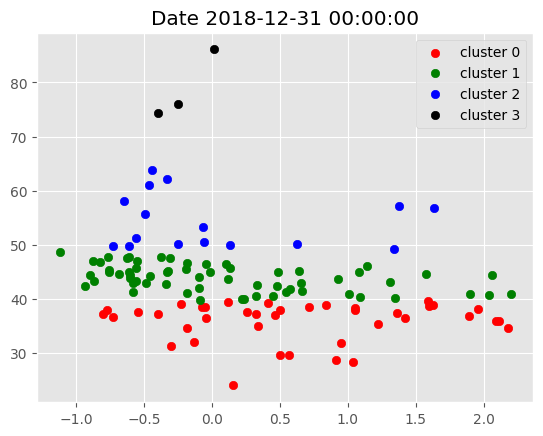

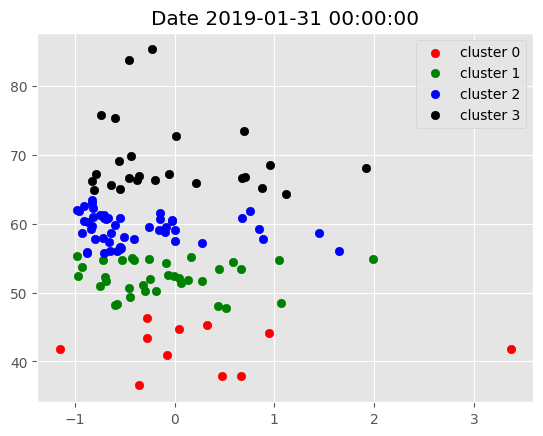

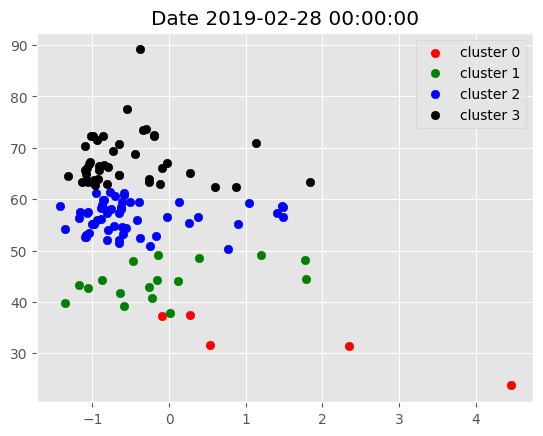

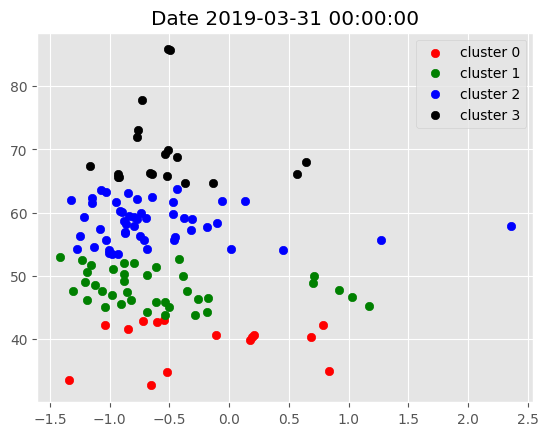

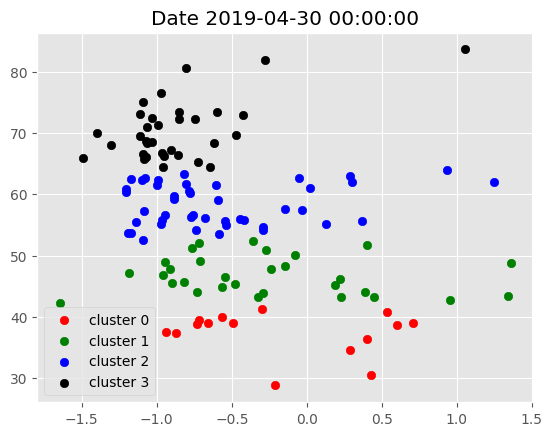

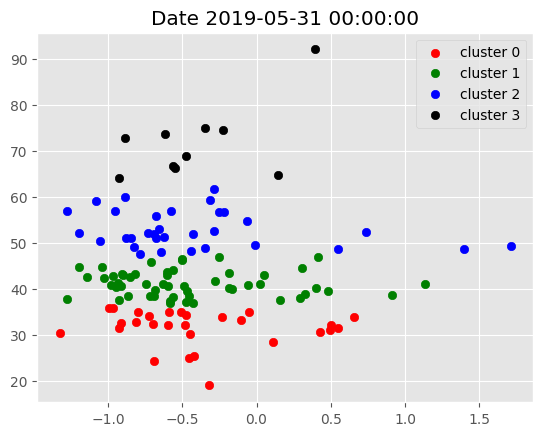

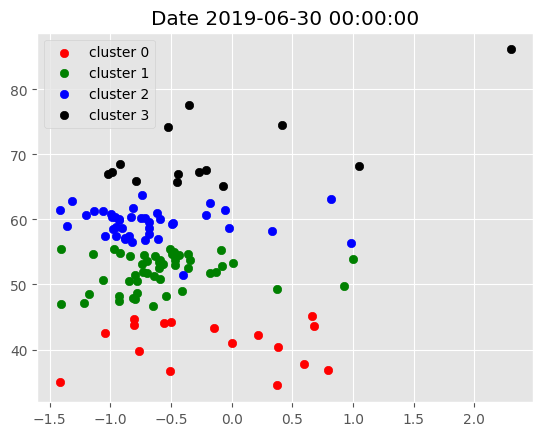

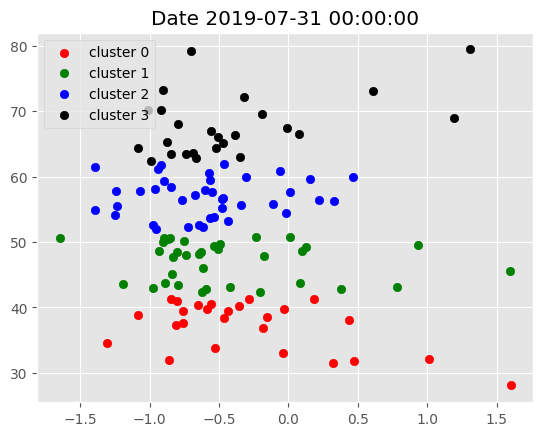

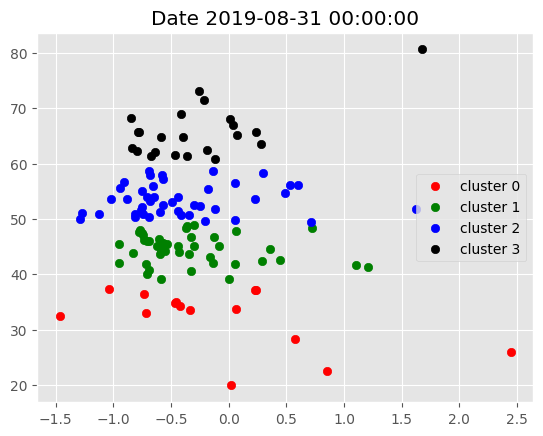

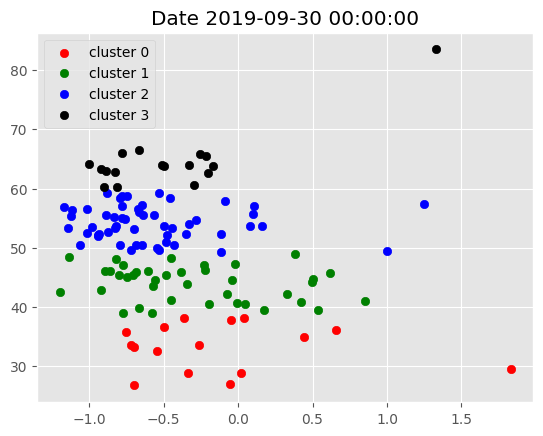

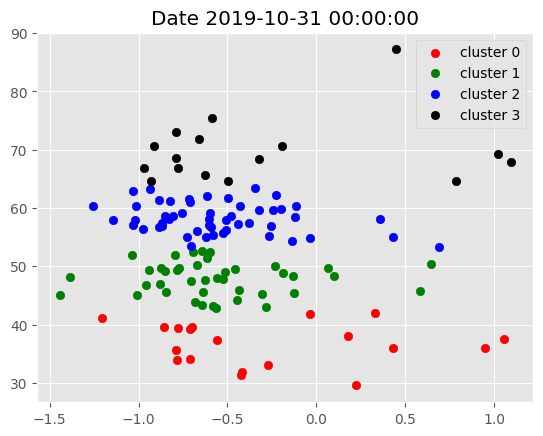

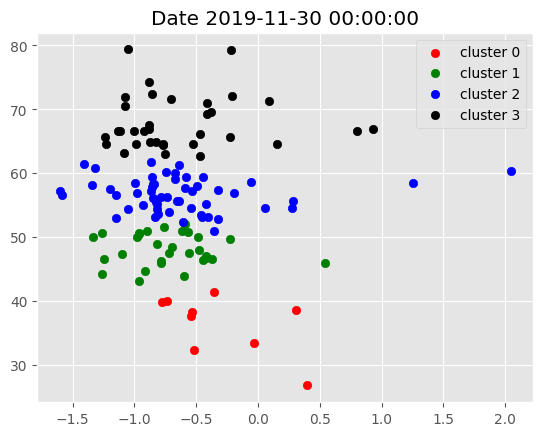

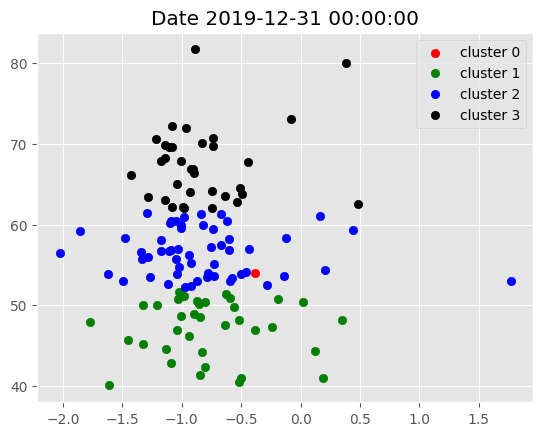

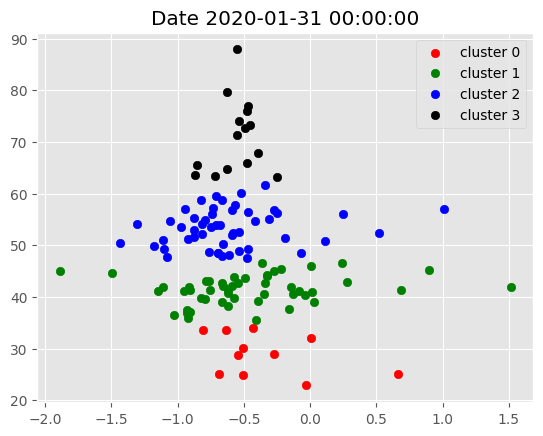

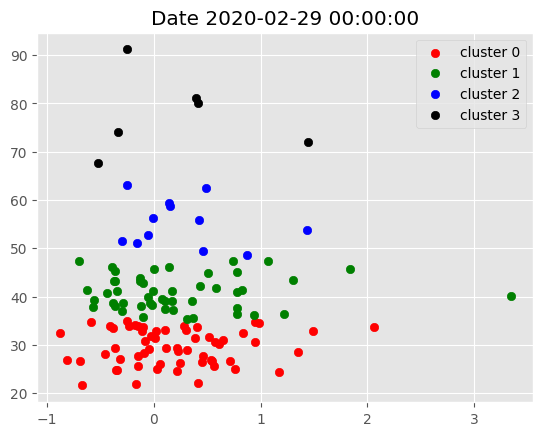

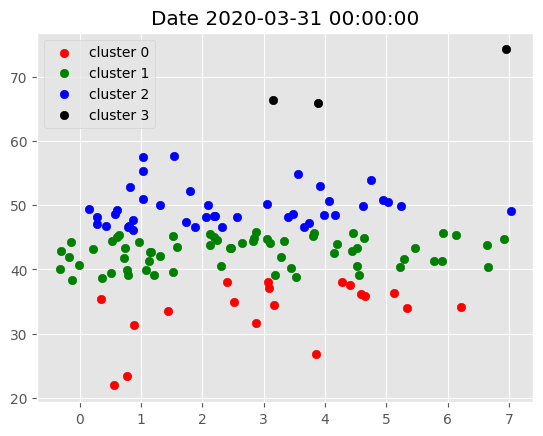

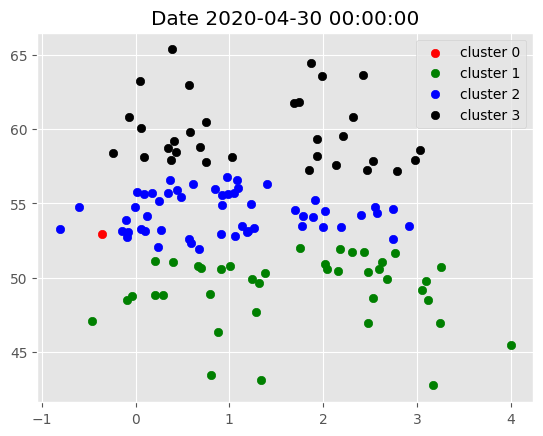

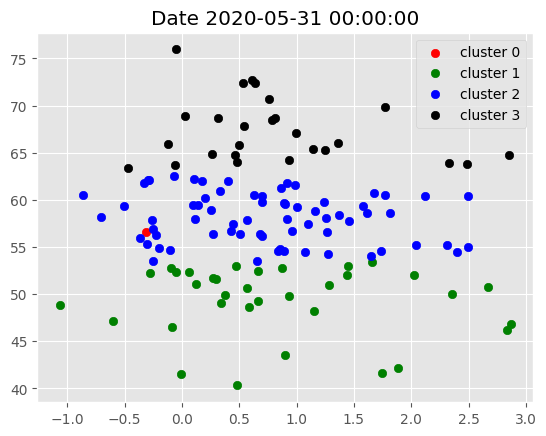

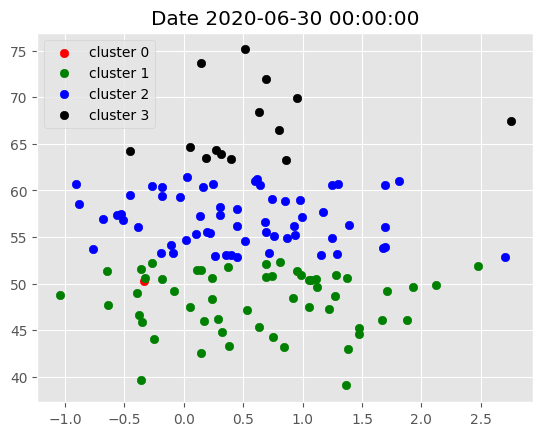

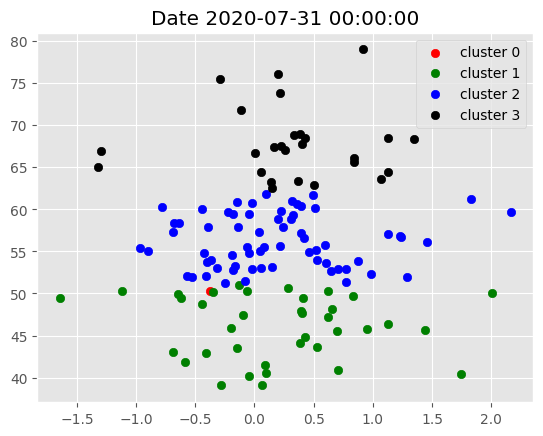

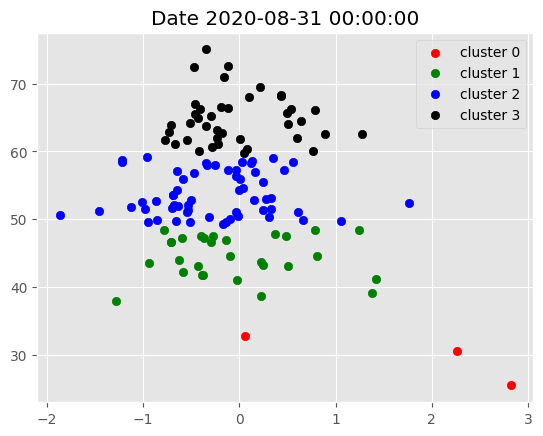

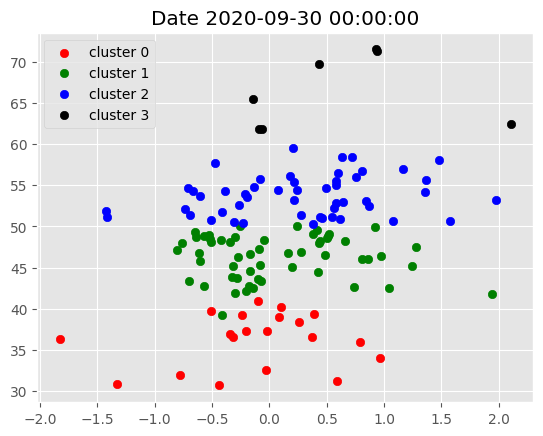

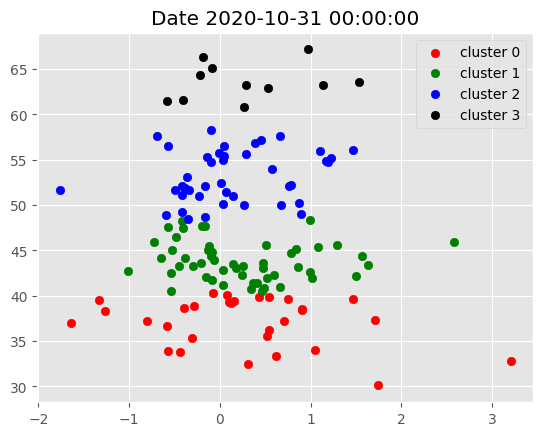

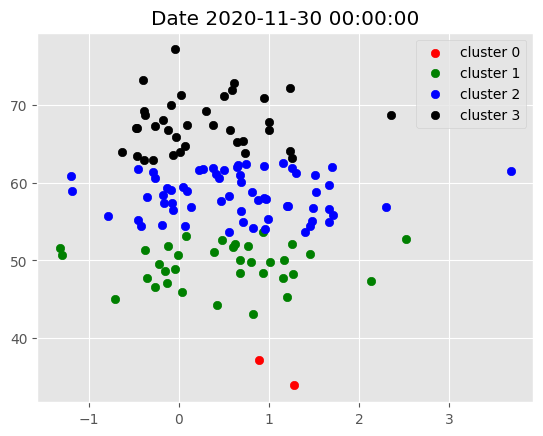

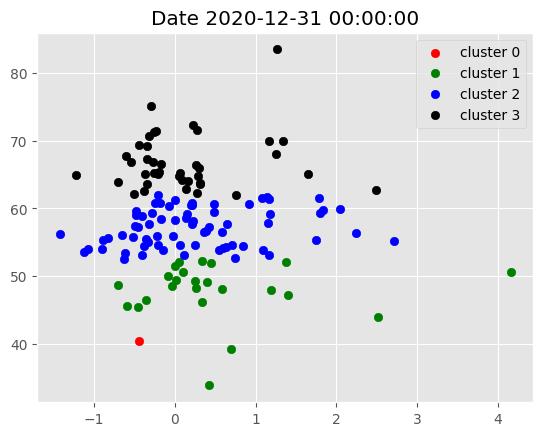

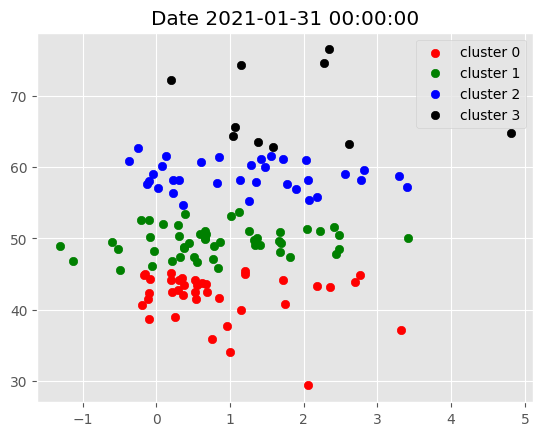

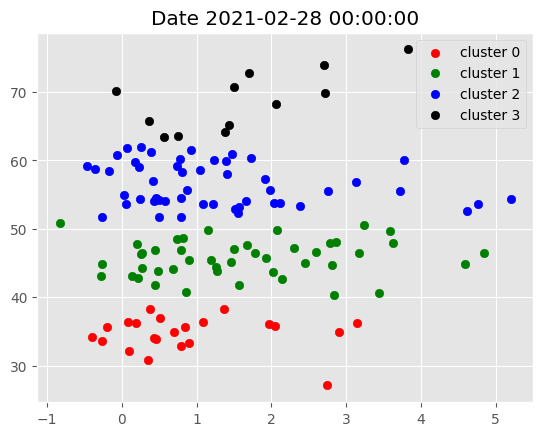

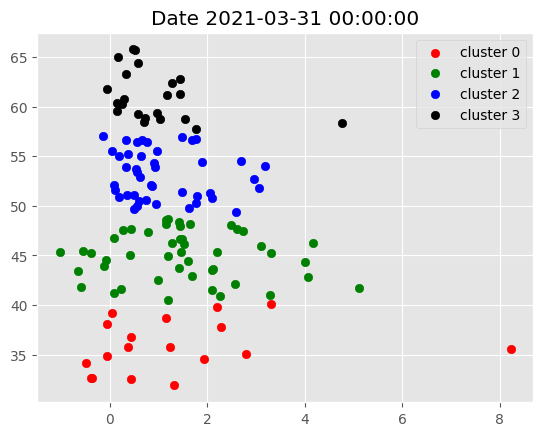

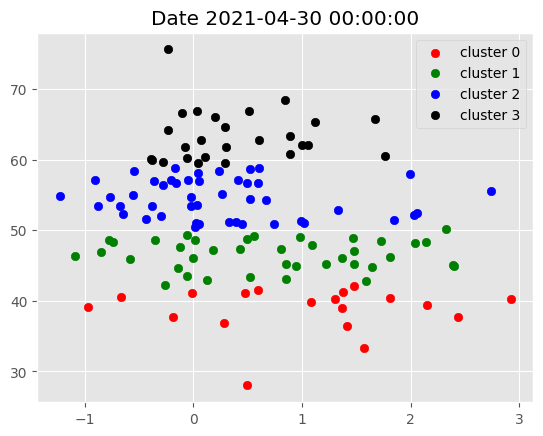

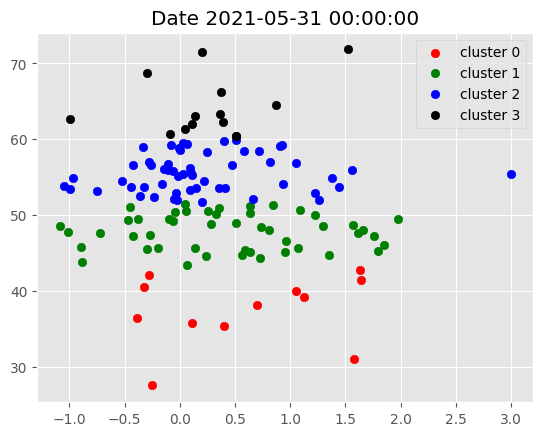

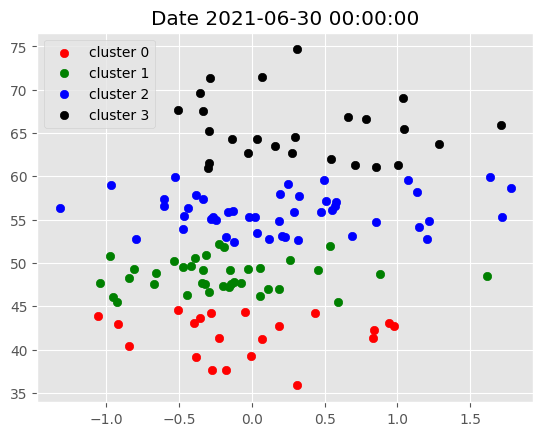

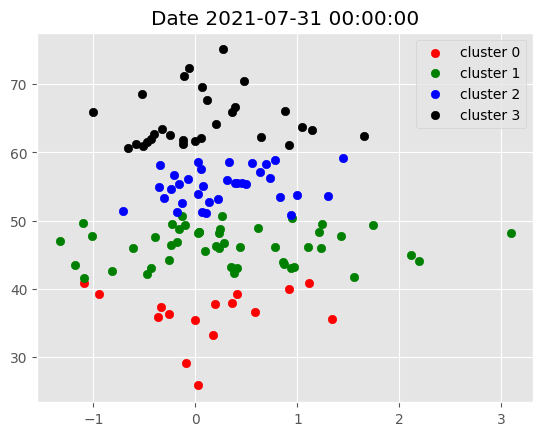

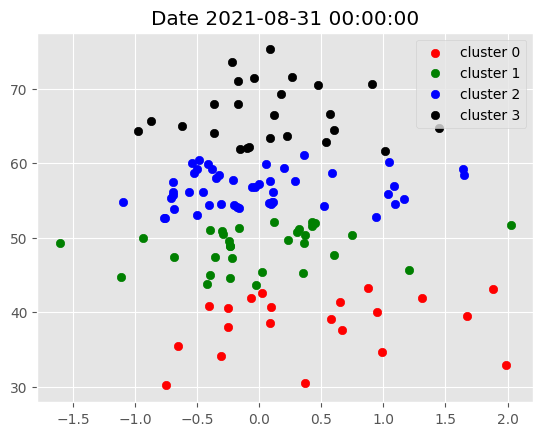

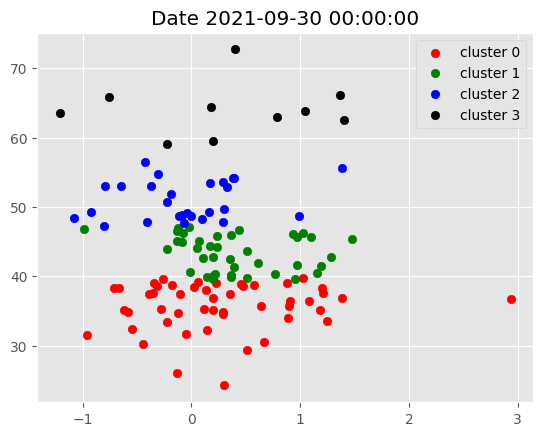

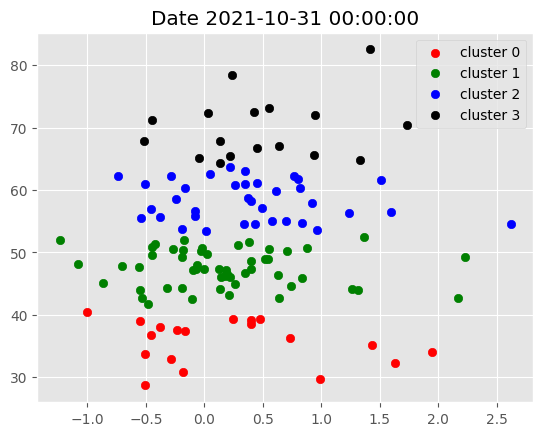

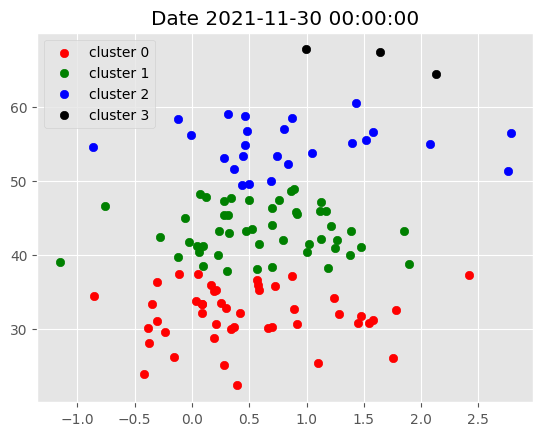

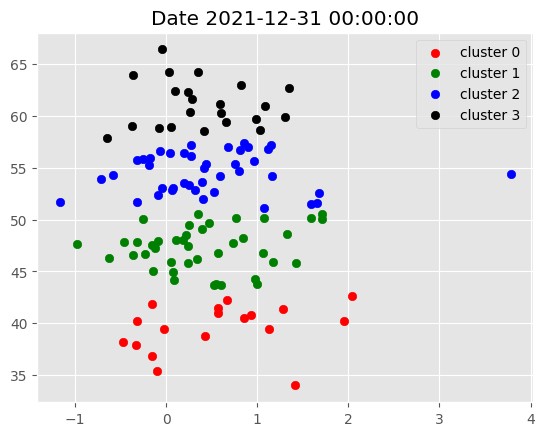

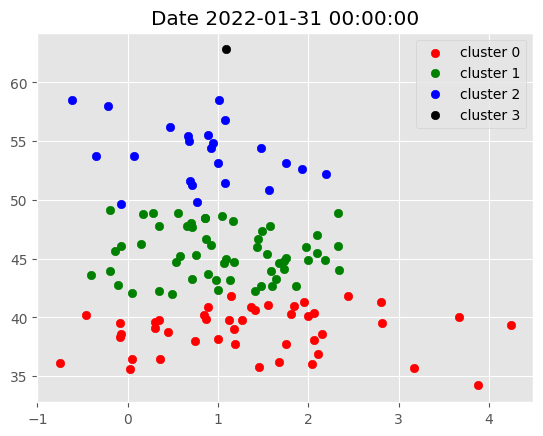

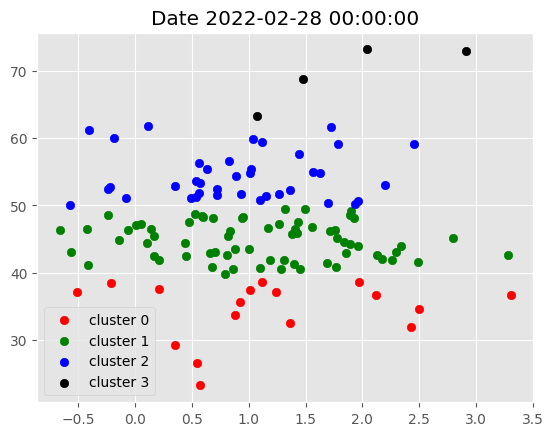

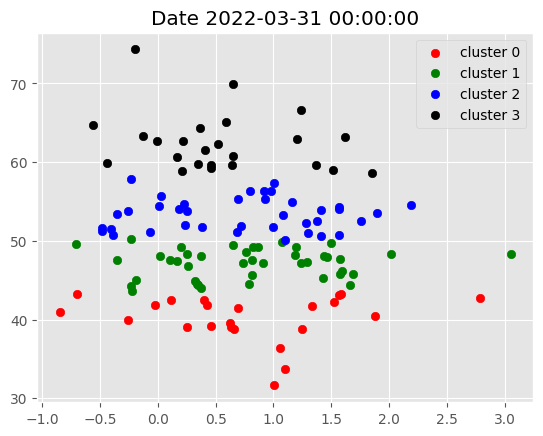

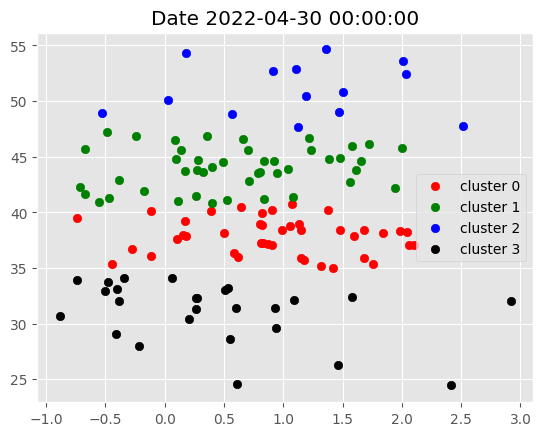

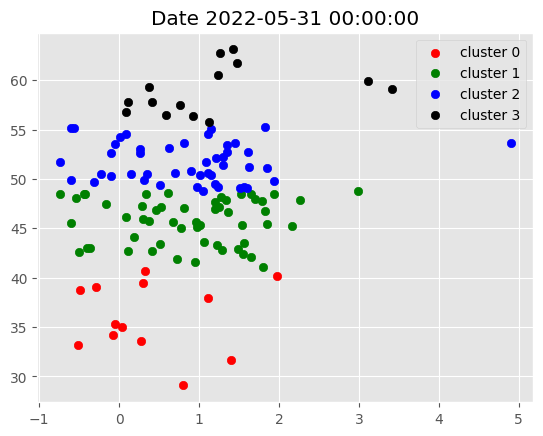

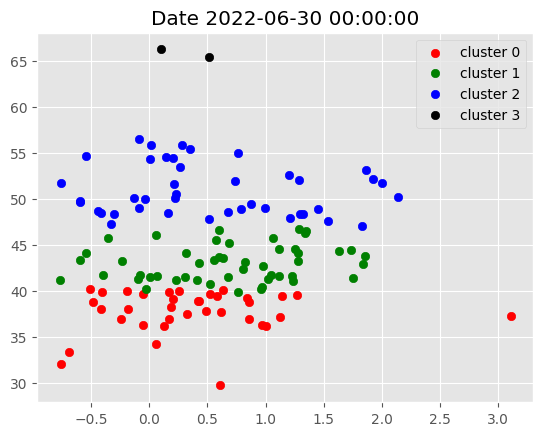

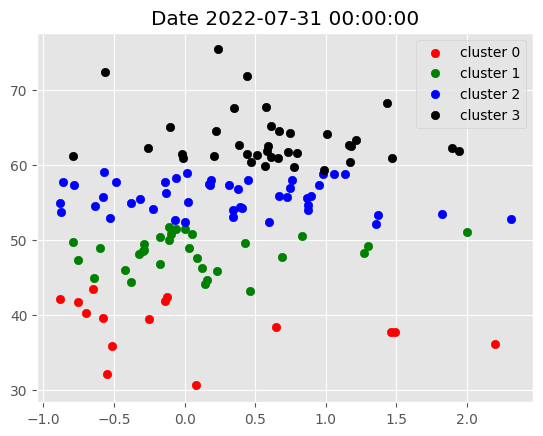

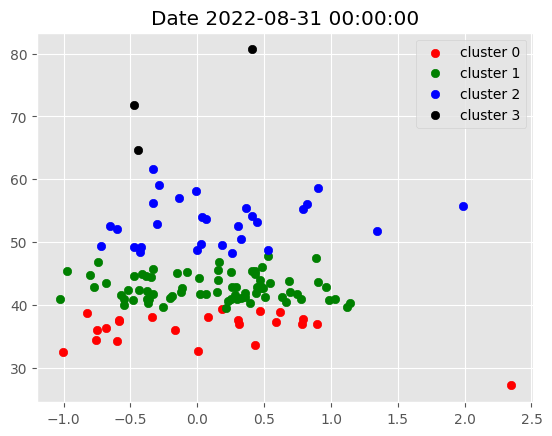

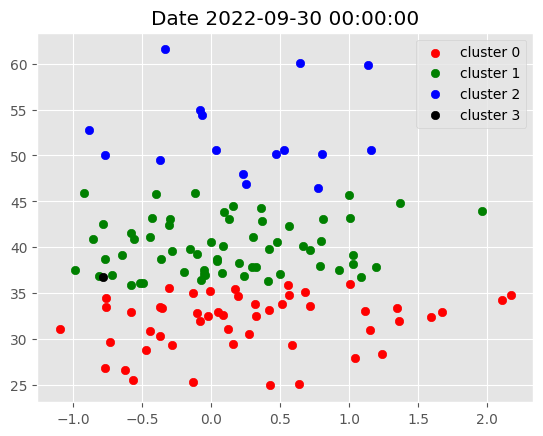

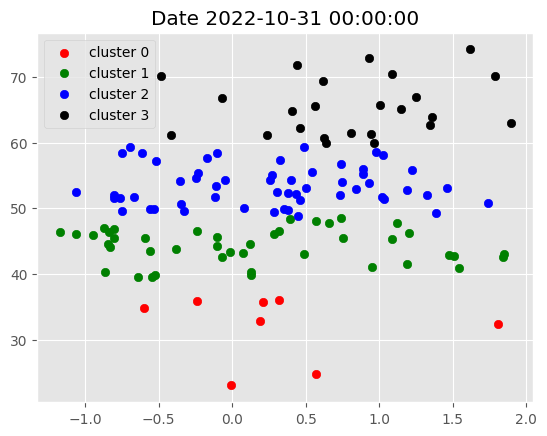

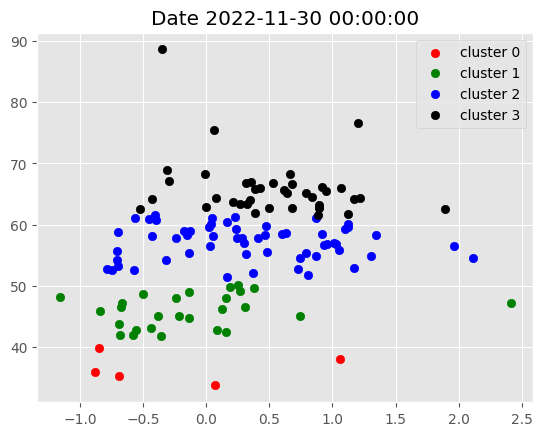

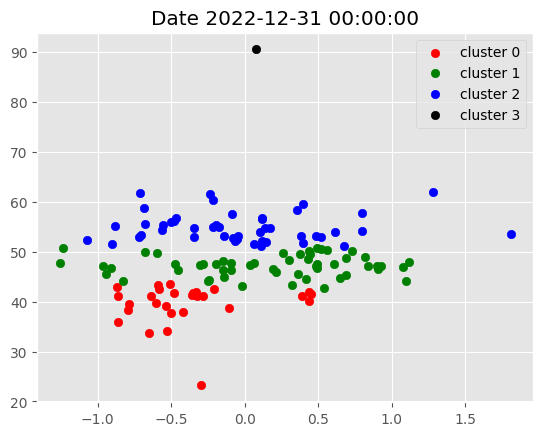

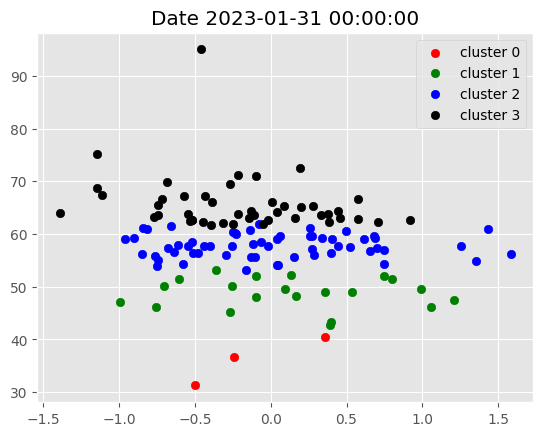

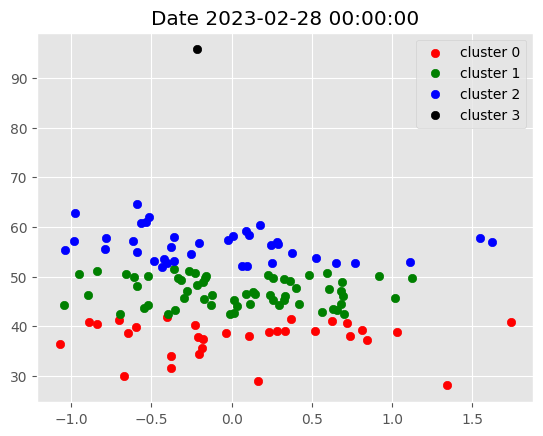

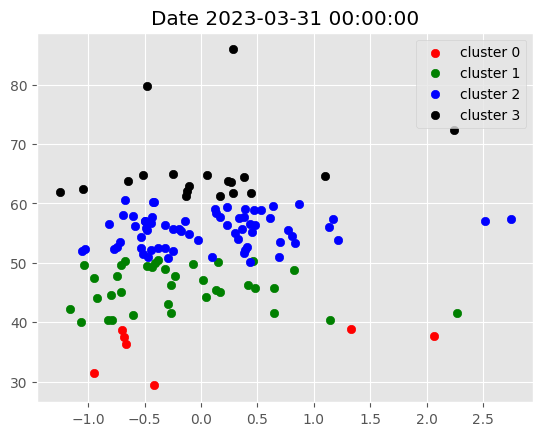

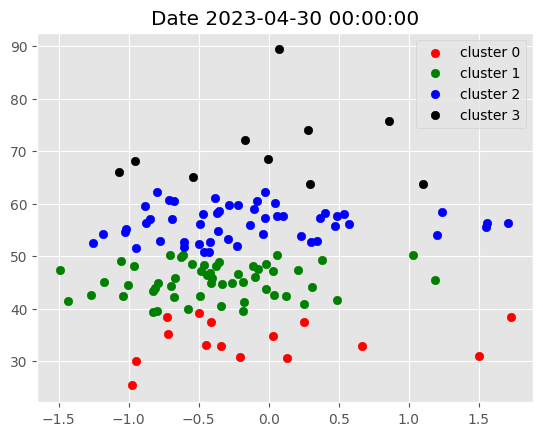

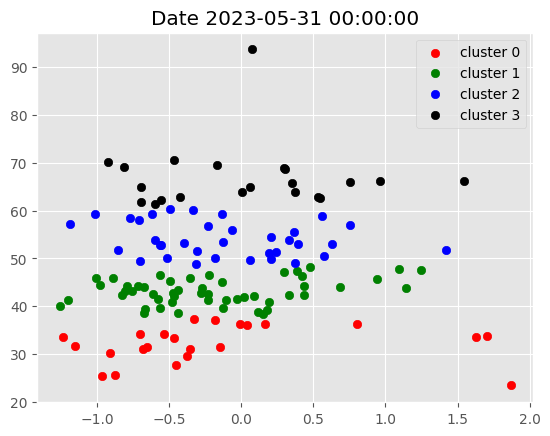

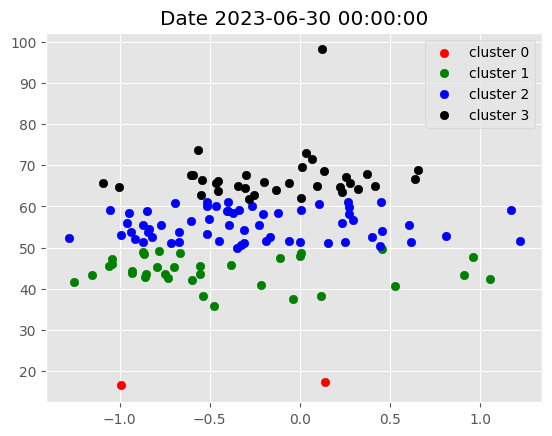

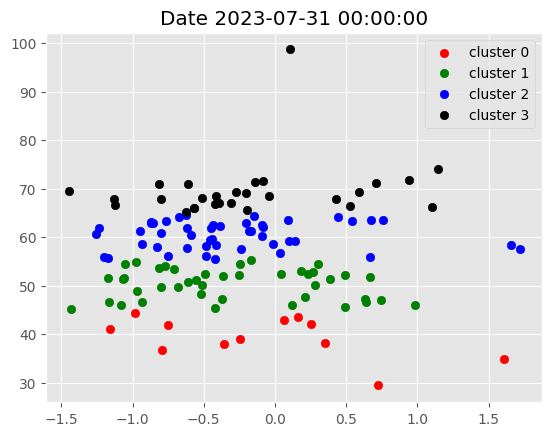

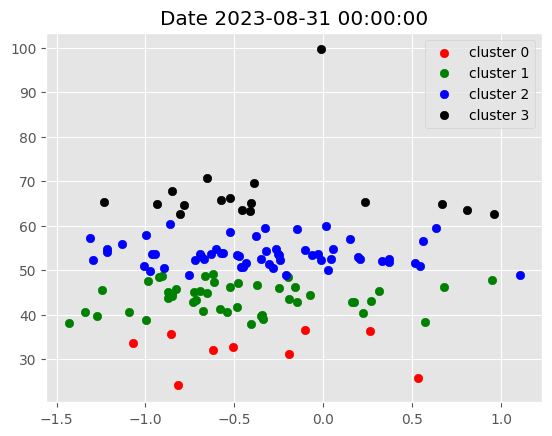

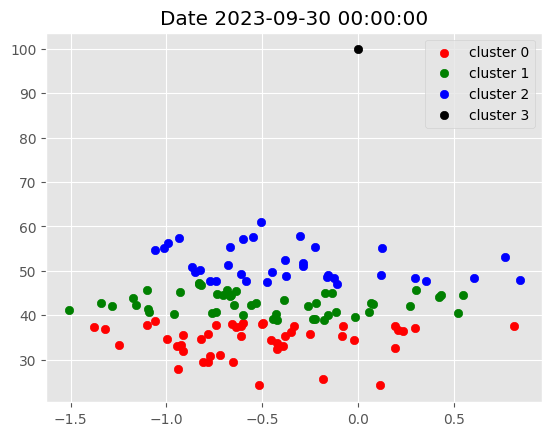

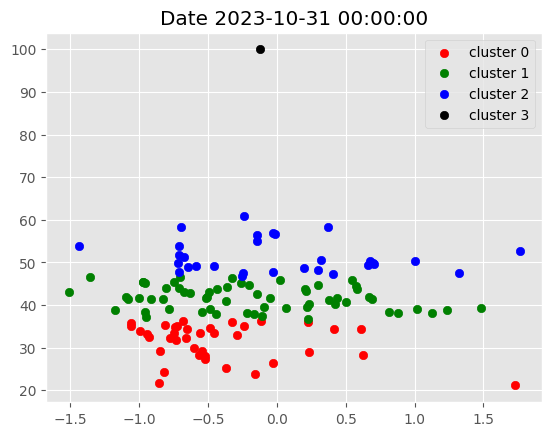

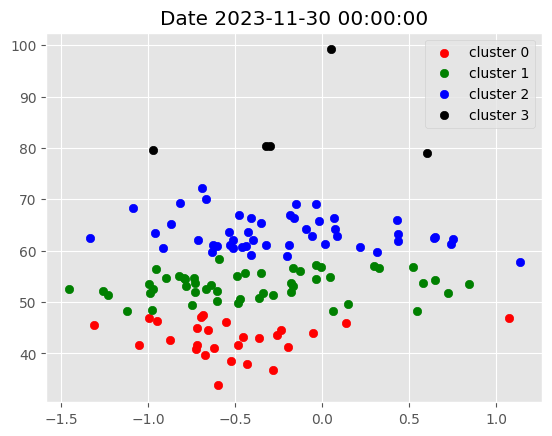

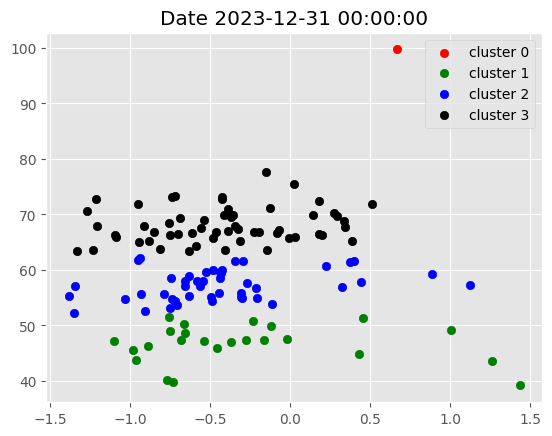

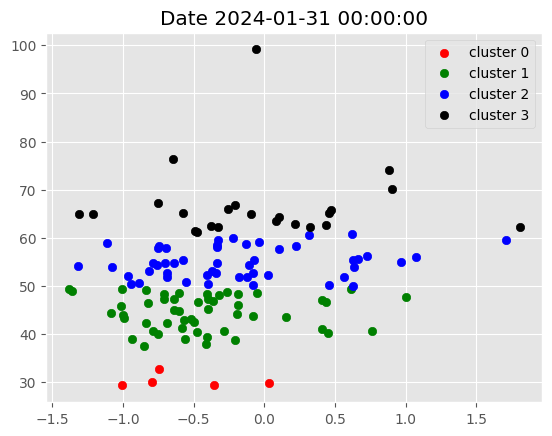

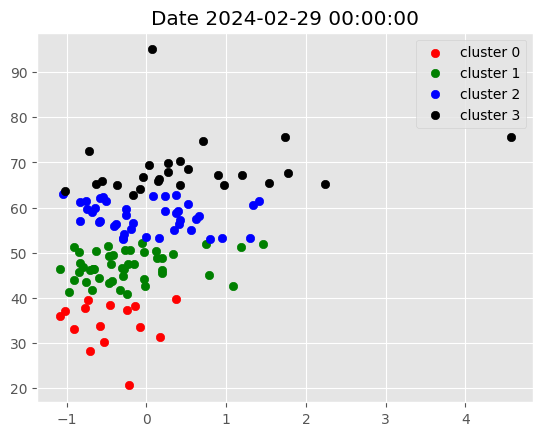

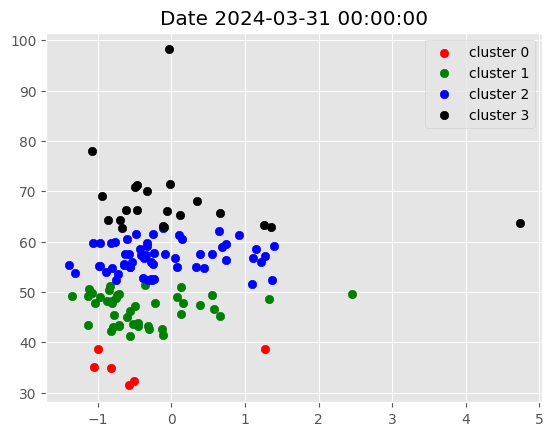

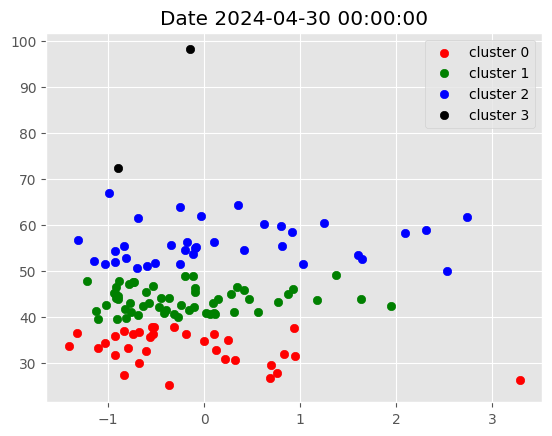

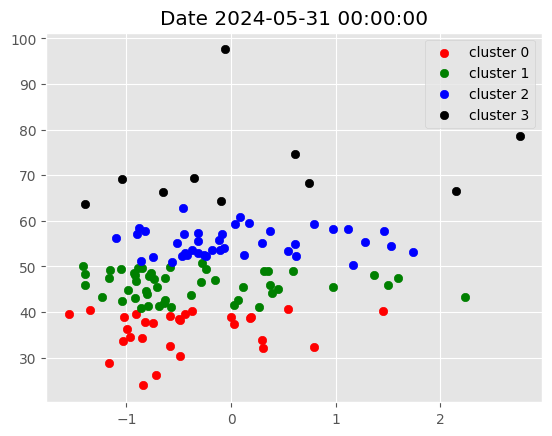

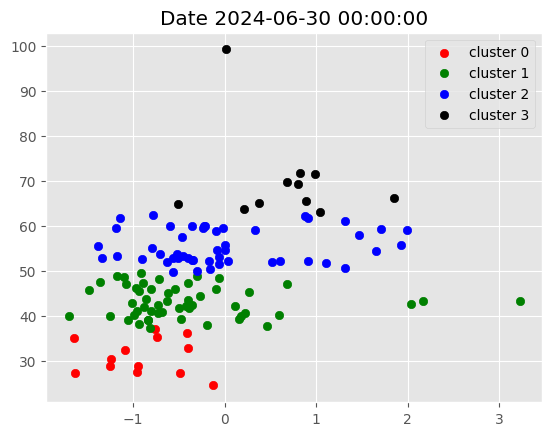

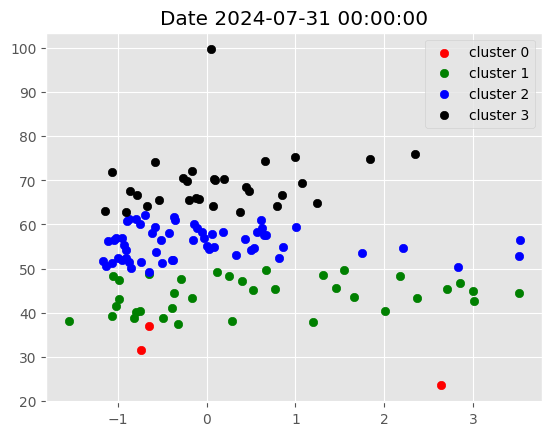

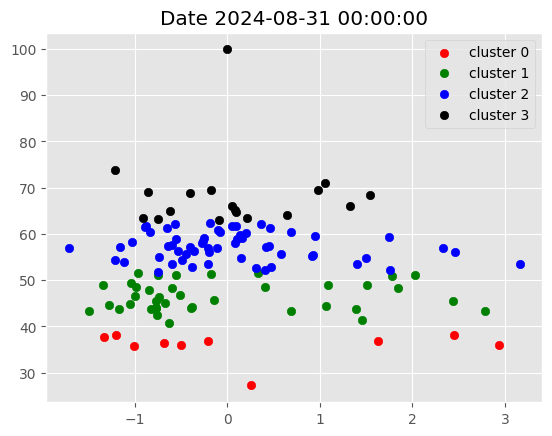

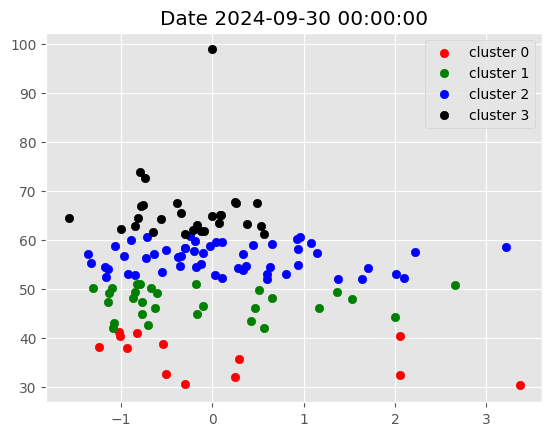

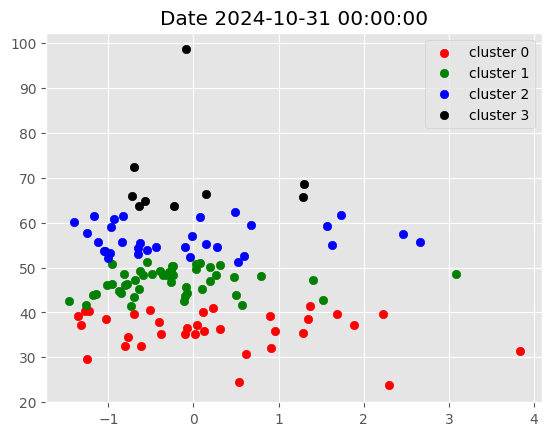

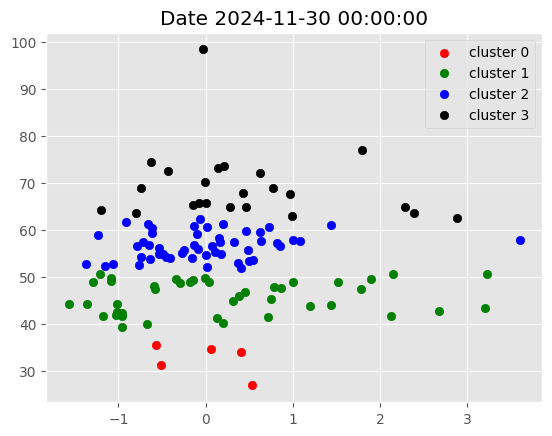

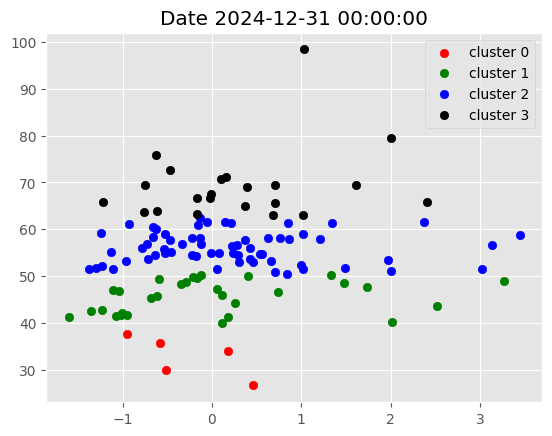

In [18]:
plt.style.use('ggplot')

for i in data.index.get_level_values('date').unique().tolist():
    
    g = data.xs(i, level=0)
    
    plt.title(f'Date {i}')
    
    plot_clusters(g)

## 7. For each month select assets based on the cluster and form a portfolio based on Efficient Frontier max sharpe ratio optimization

* First we will filter only stocks corresponding to the cluster we choose based on our hypothesis.

* Momentum is persistent and my idea would be that stocks clustered around RSI 70 centroid should continue to outperform in the following month - thus I would select stocks corresponding to cluster 3.


In [19]:
filtered_df = data[data['cluster']==3].copy()

filtered_df = filtered_df.reset_index(level=1)

filtered_df.index = filtered_df.index+pd.DateOffset(1)

filtered_df = filtered_df.reset_index().set_index(['date', 'ticker'])

dates = filtered_df.index.get_level_values('date').unique().tolist()

fixed_dates = {}

for d in dates:
    
    fixed_dates[d.strftime('%Y-%m-%d')] = filtered_df.xs(d, level=0).index.tolist()
    
fixed_dates

# convert fixed_dates to a pandas DataFrame
# Identify the last key in the dictionary
last_key = list(fixed_dates.keys())[-1]

# Extract the data associated with the last key
last_column_data = fixed_dates[last_key]

# Create a pandas DataFrame from the extracted data
watchlist = pd.DataFrame({last_key: last_column_data})
watchlist.columns.values[0] = 'Symbol'
watchlist['Exchange'] = 'NASDAQ'
watchlist['Type'] = 'Stock'

watchlist.to_csv('watchlist.csv', index=False)


# Display the DataFrame
print(watchlist)



   Symbol Exchange   Type
0    AMBA   NASDAQ  Stock
1    EQIX   NASDAQ  Stock
2    FAST   NASDAQ  Stock
3    FFIV   NASDAQ  Stock
4    FIVN   NASDAQ  Stock
5     HQY   NASDAQ  Stock
6    IUSG   NASDAQ  Stock
7    LOPE   NASDAQ  Stock
8    MGNI   NASDAQ  Stock
9     NWL   NASDAQ  Stock
10   PENN   NASDAQ  Stock
11   PTCT   NASDAQ  Stock
12    SHV   NASDAQ  Stock
13   SKYY   NASDAQ  Stock
14   URBN   NASDAQ  Stock
15      Z   NASDAQ  Stock
16   ZBRA   NASDAQ  Stock
17     ZG   NASDAQ  Stock
18   CARG   NASDAQ  Stock
19   UPWK   NASDAQ  Stock
20   FOXA   NASDAQ  Stock
21   CRSR   NASDAQ  Stock


In [20]:
# Step 1: Extract the last entry
# Get the last key based on maximum date
last_date = max(fixed_dates.keys())
last_date_stocks = fixed_dates[last_date]

# Step 2: Copy the values to a list (already in list form, directly use it)
stocks_to_save = last_date_stocks

# Step 3: Save the list to a CSV file
csv_filename = 'stocks_list.csv'
with open(csv_filename, 'w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(['Stocks'])  # Writing a header, optional
    for stock in stocks_to_save:
        writer.writerow([stock])  # Each stock in its own row

print(f"Data from the last date {last_date} has been saved to {csv_filename}.")


Data from the last date 2025-01-01 has been saved to stocks_list.csv.


### Define portfolio optimization function

* We will define a function which optimizes portfolio weights using PyPortfolioOpt package and EfficientFrontier optimizer to maximize the sharpe ratio.

* To optimize the weights of a given portfolio we would need to supply last 1 year prices to the function.

* Apply signle stock weight bounds constraint for diversification (minimum half of equaly weight and maximum 10% of portfolio).

In [21]:
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import risk_models
from pypfopt import expected_returns

def optimize_weights(prices, lower_bound=0):
    
    returns = expected_returns.mean_historical_return(prices=prices,
                                                      frequency=252)
    
    cov = risk_models.sample_cov(prices=prices,
                                 frequency=252)
    
    ef = EfficientFrontier(expected_returns=returns,
                           cov_matrix=cov,
                           weight_bounds=(lower_bound, .1),
                           solver='SCS')
    
    weights = ef.max_sharpe()
    
    return ef.clean_weights()


* Download Fresh Daily Prices Data only for short listed stocks.

In [22]:
stocks = data.index.get_level_values('ticker').unique().tolist()

new_df = yf.download(tickers=stocks,
                     start=data.index.get_level_values('date').unique()[0]-pd.DateOffset(months=12),
                     end=data.index.get_level_values('date').unique()[-1])

new_df

[*********************100%***********************]  157 of 157 completed

157 Failed downloads:
['NWE', 'HOLX', 'DOX', 'NDSN', 'AMD', 'CRNC', 'ISRG', 'FFIN', 'SAIA', 'HALO', 'BHF', 'ZLAB', 'IDXX', 'FAST', 'FIVN', 'ANGI', 'LKQ', 'VXUS', 'SSRM', 'JKHY', 'DIOD', 'VGIT', 'APPN', 'JBHT', 'MGNI', 'IUSB', 'TER', 'LIVN', 'SDGR', 'MEDP', 'BIDU', 'NARI', 'HAIN', 'DOCU', 'IOVA', 'UPWK', 'INGN', 'IUSG', 'HSIC', 'KC', 'EH', 'SNBR', 'SHV', 'TREE', 'OPEN', 'APA', 'BMRN', 'AMBA', 'LBTYA', 'IRWD', 'LNW', 'FLEX', 'PENN', 'IBB', 'FSLR', 'IRDM', 'AEIS', 'NTAP', 'PFG', 'EBAY', 'VRNS', 'CLOV', 'PYPL', 'CGC', 'AMAT', 'KLAC', 'BJRI', 'GLPG', 'NTGR', 'ULTA', 'VKTX', 'RARE', 'XRX', 'SBRA', 'SANM', 'BAND', 'COLM', 'FGEN', 'NXPI', 'IEI', 'NWL', 'DLTR', 'FOXA', 'UNIT', 'FTDR', 'TXG', 'INVA', 'AKAM', 'RGNX', 'NKLA', 'FITB', 'LOPE', 'TXMD', 'JACK', 'CRSR', 'SKYY', 'MKTX', 'LAMR', 'NBIX', 'GOOGL', 'CHTR', 'PARA', 'MXL', 'CDLX', 'FOLD', 'FCNCA', 'IPGP', 'TENB', 'SIMO', 'NTES', 'NAVI', 'MIDD', 'ACHC', 'PEP', 'PTCT', 'V

Empty DataFrame
Columns: [(Adj Close, ACHC), (Adj Close, ACWI), (Adj Close, ADBE), (Adj Close, AEIS), (Adj Close, AKAM), (Adj Close, AMAT), (Adj Close, AMBA), (Adj Close, AMD), (Adj Close, AMRN), (Adj Close, ANGI), (Adj Close, APA), (Adj Close, APPN), (Adj Close, APPS), (Adj Close, ASML), (Adj Close, AVAV), (Adj Close, BAND), (Adj Close, BHF), (Adj Close, BIDU), (Adj Close, BJRI), (Adj Close, BMRN), (Adj Close, CARG), (Adj Close, CDLX), (Adj Close, CGC), (Adj Close, CHDN), (Adj Close, CHKP), (Adj Close, CHTR), (Adj Close, CHX), (Adj Close, CLOV), (Adj Close, CMCSA), (Adj Close, COLM), (Adj Close, CRNC), (Adj Close, CRSR), (Adj Close, CRWD), (Adj Close, CSX), (Adj Close, DIOD), (Adj Close, DLTR), (Adj Close, DOCU), (Adj Close, DOX), (Adj Close, EBAY), (Adj Close, EH), (Adj Close, EQIX), (Adj Close, ETSY), (Adj Close, FAST), (Adj Close, FATE), (Adj Close, FCNCA), (Adj Close, FFIN), (Adj Close, FFIV), (Adj Close, FGEN), (Adj Close, FITB), (Adj Close, FIVN), (Adj Close, FLEX), (Adj Close, FOLD), (Adj Close, FOXA), (Adj Close, FSLR), (Adj Close, FTDR), (Adj Close, GLNG), (Adj Close, GLPG), (Adj Close, GLPI), (Adj Close, GOOGL), (Adj Close, HAIN), (Adj Close, HALO), (Adj Close, HOLX), (Adj Close, HQY), (Adj Close, HSIC), (Adj Close, IBB), (Adj Close, IDXX), (Adj Close, IEI), (Adj Close, IGIB), (Adj Close, INGN), (Adj Close, INVA), (Adj Close, IOVA), (Adj Close, IPGP), (Adj Close, IRDM), (Adj Close, IRWD), (Adj Close, ISRG), (Adj Close, IUSB), (Adj Close, IUSG), (Adj Close, JACK), (Adj Close, JBHT), (Adj Close, JKHY), (Adj Close, KC), (Adj Close, KLAC), (Adj Close, LAMR), (Adj Close, LBRDA), (Adj Close, LBTYA), (Adj Close, LIVN), (Adj Close, LKQ), (Adj Close, LNT), (Adj Close, LNW), (Adj Close, LOPE), (Adj Close, MEDP), (Adj Close, MGNI), (Adj Close, MIDD), (Adj Close, MKTX), (Adj Close, MXL), (Adj Close, NARI), (Adj Close, NAVI), (Adj Close, NBIX), (Adj Close, NDSN), (Adj Close, NKLA), ...]
Index: []

[0 rows x 942 columns]

* Calculate daily returns for each stock which could land up in our portfolio.

* Then loop over each month start, select the stocks for the month and calculate their weights for the next month.

* If the maximum sharpe ratio optimization fails for a given month, apply equally-weighted weights.

* Calculated each day portfolio return.

In [23]:
returns_dataframe = np.log(new_df['Adj Close']).diff()

portfolio_df = pd.DataFrame()

for start_date in fixed_dates.keys():
    
    try:

        end_date = (pd.to_datetime(start_date)+pd.offsets.MonthEnd(0)).strftime('%Y-%m-%d')

        cols = fixed_dates[start_date]

        optimization_start_date = (pd.to_datetime(start_date)-pd.DateOffset(months=12)).strftime('%Y-%m-%d')

        optimization_end_date = (pd.to_datetime(start_date)-pd.DateOffset(days=1)).strftime('%Y-%m-%d')
        
        optimization_df = new_df[optimization_start_date:optimization_end_date]['Adj Close'][cols]
        
        success = False
        try:
            weights = optimize_weights(prices=optimization_df,
                                   lower_bound=round(1/(len(optimization_df.columns)*2),3))

            weights = pd.DataFrame(weights, index=pd.Series(0))
            
            success = True
        except:
            print(f'Max Sharpe Optimization failed for {start_date}, Continuing with Equal-Weights')
        
        if success==False:
            weights = pd.DataFrame([1/len(optimization_df.columns) for i in range(len(optimization_df.columns))],
                                     index=optimization_df.columns.tolist(),
                                     columns=pd.Series(0)).T
        
        temp_df = returns_dataframe[start_date:end_date]

        temp_df = temp_df.stack().to_frame('return').reset_index(level=0)\
                   .merge(weights.stack().to_frame('weight').reset_index(level=0, drop=True),
                          left_index=True,
                          right_index=True)\
                   .reset_index().set_index(['Date', 'index']).unstack().stack()

        temp_df.index.names = ['date', 'ticker']

        temp_df['weighted_return'] = temp_df['return']*temp_df['weight']

        temp_df = temp_df.groupby(level=0)['weighted_return'].sum().to_frame('Strategy Return')

        portfolio_df = pd.concat([portfolio_df, temp_df], axis=0)
    
    except Exception as e:
        print(e)

portfolio_df = portfolio_df.drop_duplicates()

portfolio_df

Max Sharpe Optimization failed for 2019-01-01, Continuing with Equal-Weights
"None of ['index'] are in the columns"
Max Sharpe Optimization failed for 2019-02-01, Continuing with Equal-Weights
"None of ['index'] are in the columns"
Max Sharpe Optimization failed for 2019-03-01, Continuing with Equal-Weights
"None of ['index'] are in the columns"
Max Sharpe Optimization failed for 2019-04-01, Continuing with Equal-Weights
"None of ['index'] are in the columns"
Max Sharpe Optimization failed for 2019-05-01, Continuing with Equal-Weights
"None of ['index'] are in the columns"
Max Sharpe Optimization failed for 2019-06-01, Continuing with Equal-Weights
"None of ['index'] are in the columns"
Max Sharpe Optimization failed for 2019-07-01, Continuing with Equal-Weights
"None of ['index'] are in the columns"
Max Sharpe Optimization failed for 2019-08-01, Continuing with Equal-Weights
"None of ['index'] are in the columns"
Max Sharpe Optimization failed for 2019-09-01, Continuing with Equal-Wei

""


## 8. Visualize Portfolio returns and compare to SP500 returns.

In [42]:
spy = yf.download(tickers='SPY',
                  start='2015-01-01',
                  end=dt.date.today())

spy_ret = np.log(spy[['Adj Close']]).diff().dropna().rename({'Adj Close':'SPY Buy&Hold'}, axis=1)

portfolio_df = portfolio_df.merge(spy_ret,
                                  left_index=True,
                                  right_index=True)

portfolio_df

[*********************100%***********************]  1 of 1 completed


Price,SPY Buy&Hold_x,SPY Buy&Hold_y,SPY Buy&Hold
Ticker,SPY,SPY,SPY
Date,,,


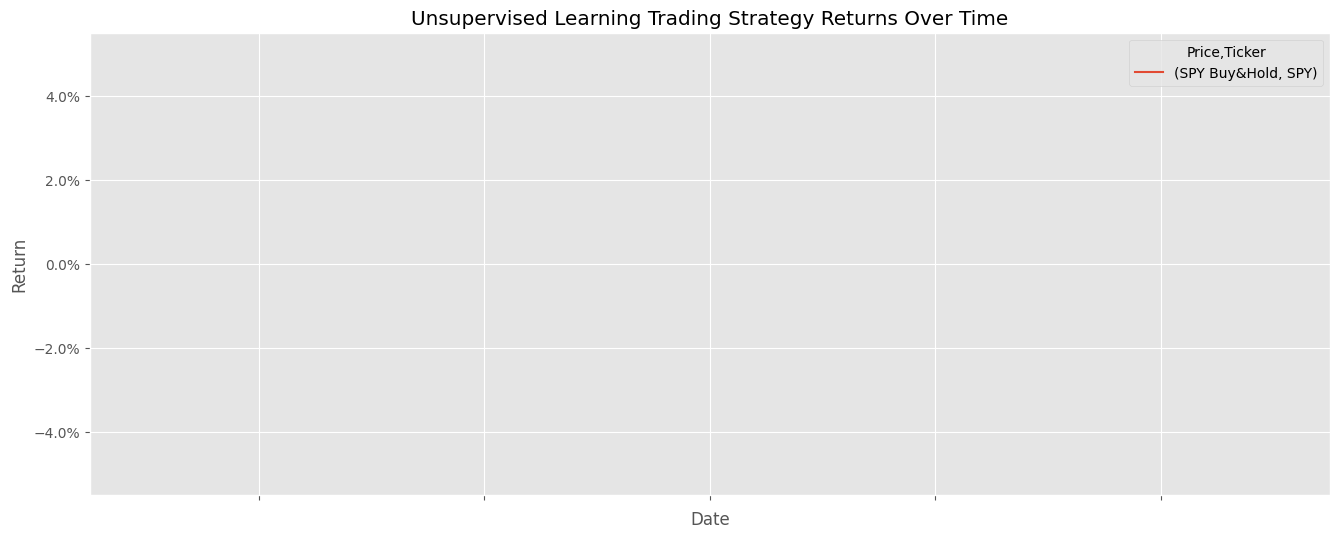

In [25]:
import matplotlib.ticker as mtick

plt.style.use('ggplot')

portfolio_cumulative_return = np.exp(np.log1p(portfolio_df).cumsum())-1

portfolio_cumulative_return[:'2023-09-29'].plot(figsize=(16,6))

plt.title('Unsupervised Learning Trading Strategy Returns Over Time')

plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(1))

plt.ylabel('Return')

plt.show()


# Twitter Sentiment Investing Strategy

## 1. Load Twitter Sentiment Data

* Load the twitter sentiment dataset, set the index, calculat engagement ratio and filter out stocks with no significant twitter activity.

In [26]:
# import pandas as pd
# import numpy as np
# import matplotlib.pyplot as plt
# import datetime as dt
# import yfinance as yf
# import os
# plt.style.use('ggplot')

# data_folder = 'C:/Users/user/Desktop/Python Scripts'

# sentiment_df = pd.read_csv(os.path.join(data_folder, 'sentiment_data.csv'))

# sentiment_df['date'] = pd.to_datetime(sentiment_df['date'])

# sentiment_df = sentiment_df.set_index(['date', 'symbol'])

# sentiment_df['engagement_ratio'] = sentiment_df['twitterComments']/sentiment_df['twitterLikes']

# sentiment_df = sentiment_df[(sentiment_df['twitterLikes']>20)&(sentiment_df['twitterComments']>10)]

# sentiment_df

## 2. Aggregate Monthly and calculate average sentiment for the month

* Aggregate on a monthly level and calculate average monthly metric, for the one we choose.

In [27]:
# aggragated_df = (sentiment_df.reset_index('symbol').groupby([pd.Grouper(freq='M'), 'symbol'])
#                     [['engagement_ratio']].mean())

# aggragated_df['rank'] = (aggragated_df.groupby(level=0)['engagement_ratio']
#                          .transform(lambda x: x.rank(ascending=False)))

# aggragated_df

## 3. Select Top 5 Stocks based on their cross-sectional ranking for each month

* Select top 5 stocks by rank for each month and fix the date to start at beginning of next month.

In [28]:
# filtered_df = aggragated_df[aggragated_df['rank']<6].copy()

# filtered_df = filtered_df.reset_index(level=1)

# filtered_df.index = filtered_df.index+pd.DateOffset(1)

# filtered_df = filtered_df.reset_index().set_index(['date', 'symbol'])

# filtered_df.head(20)

## 4. Extract the stocks to form portfolios with at the start of each new month

* Create a dictionary containing start of month and corresponded selected stocks.

In [29]:
# dates = filtered_df.index.get_level_values('date').unique().tolist()

# fixed_dates = {}

# for d in dates:
    
#     fixed_dates[d.strftime('%Y-%m-%d')] = filtered_df.xs(d, level=0).index.tolist()
    
# fixed_dates

## 5. Download fresh stock prices for only selected/shortlisted stocks

In [30]:
# stocks_list = sentiment_df.index.get_level_values('symbol').unique().tolist()

# prices_df = yf.download(tickers=stocks_list,
#                         start='2021-01-01',
#                         end='2023-03-01')

## 6. Calculate Portfolio Returns with monthly rebalancing


In [31]:
# returns_df = np.log(prices_df['Adj Close']).diff().dropna()

# portfolio_df = pd.DataFrame()

# for start_date in fixed_dates.keys():
    
#     end_date = (pd.to_datetime(start_date)+pd.offsets.MonthEnd()).strftime('%Y-%m-%d')
    
#     cols = fixed_dates[start_date]
    
#     temp_df = returns_df[start_date:end_date][cols].mean(axis=1).to_frame('portfolio_return')
    
#     portfolio_df = pd.concat([portfolio_df, temp_df], axis=0)
    
# portfolio_df

## 7. Download NASDAQ/QQQ prices and calculate returns to compare to our strategy

In [32]:
# qqq_df = yf.download(tickers='QQQ',
#                      start='2021-01-01',
#                      end='2023-03-01')

# qqq_ret = np.log(qqq_df['Adj Close']).diff().to_frame('nasdaq_return')

# portfolio_df = portfolio_df.merge(qqq_ret,
#                                   left_index=True,
#                                   right_index=True)

# portfolio_df

In [33]:
# portfolios_cumulative_return = np.exp(np.log1p(portfolio_df).cumsum()).sub(1)

# portfolios_cumulative_return.plot(figsize=(16,6))

# plt.title('Twitter Engagement Ratio Strategy Return Over Time')

# plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(1))

# plt.ylabel('Return')

# plt.show()

# Intraday Strategy Using GARCH Model


* Using simulated daily data and intraday 5-min data.
* Load Daily and 5-minute data.
* Define function to fit GARCH model on the daily data and predict 1-day ahead volatility in a rolling window.
* Calculate prediction premium and form a daily signal from it.
* Merge with intraday data and calculate intraday indicators to form the intraday signal.
* Generate the position entry and hold until the end of the day.
* Calculate final strategy returns.

## 1. Load Simulated Daily and Simulated 5-minute data.

* We are loading both datasets, set the indexes and calculate daily log returns.

In [34]:
# import matplotlib.pyplot as plt
# from arch import arch_model
# import pandas_ta
# import pandas as pd
# import numpy as np
# import os

# data_folder = 'C:/Users/user/Desktop/Python Scripts'

# daily_df = pd.read_csv(os.path.join(data_folder, 'simulated_daily_data.csv'))

# daily_df = daily_df.drop('Unnamed: 7', axis=1)

# daily_df['Date'] = pd.to_datetime(daily_df['Date'])

# daily_df = daily_df.set_index('Date')


# intraday_5min_df = pd.read_csv(os.path.join(data_folder, 'simulated_5min_data.csv'))

# intraday_5min_df = intraday_5min_df.drop('Unnamed: 6', axis=1)

# intraday_5min_df['datetime'] = pd.to_datetime(intraday_5min_df['datetime'])

# intraday_5min_df = intraday_5min_df.set_index('datetime')

# intraday_5min_df['date'] = pd.to_datetime(intraday_5min_df.index.date)

# intraday_5min_df

## 2. Define function to fit GARCH model and predict 1-day ahead volatility in a rolling window.

* We are first calculating the 6-month rolling variance and then we are creating a function in a 6-month rolling window to fit a garch model and predict the next day variance.

In [35]:
# daily_df['log_ret'] = np.log(daily_df['Adj Close']).diff()

# daily_df['variance'] = daily_df['log_ret'].rolling(180).var()

# daily_df = daily_df['2020':]

# def predict_volatility(x):
    
#     best_model = arch_model(y=x,
#                             p=1,
#                             q=3).fit(update_freq=5,
#                                      disp='off')
    
#     variance_forecast = best_model.forecast(horizon=1).variance.iloc[-1,0]

#     print(x.index[-1])
    
#     return variance_forecast

# daily_df['predictions'] = daily_df['log_ret'].rolling(180).apply(lambda x: predict_volatility(x))

# daily_df = daily_df.dropna()

# daily_df

## 3. Calculate prediction premium and form a daily signal from it.

* We are calculating the prediction premium. And calculate its 6-month rolling standard deviation.

* From this we are creating our daily signal.

In [36]:
# daily_df['prediction_premium'] = (daily_df['predictions']-daily_df['variance'])/daily_df['variance']

# daily_df['premium_std'] = daily_df['prediction_premium'].rolling(180).std()

# daily_df['signal_daily'] = daily_df.apply(lambda x: 1 if (x['prediction_premium']>x['premium_std'])
#                                          else (-1 if (x['prediction_premium']<x['premium_std']*-1) else np.nan),
#                                          axis=1)

# daily_df['signal_daily'] = daily_df['signal_daily'].shift()

# daily_df

In [37]:
# plt.style.use('ggplot')

# daily_df['signal_daily'].plot(kind='hist')

# plt.show()

## 4. Merge with intraday data and calculate intraday indicators to form the intraday signal.

* Calculate all intraday indicators and intraday signal.

In [38]:
# final_df = intraday_5min_df.reset_index()\
#                             .merge(daily_df[['signal_daily']].reset_index(),
#                                    left_on='date',
#                                    right_on='Date')\
#                             .drop(['date','Date'], axis=1)\
#                             .set_index('datetime')

# final_df['rsi'] = pandas_ta.rsi(close=final_df['close'],
#                                 length=20)

# final_df['lband'] = pandas_ta.bbands(close=final_df['close'],
#                                      length=20).iloc[:,0]

# final_df['uband'] = pandas_ta.bbands(close=final_df['close'],
#                                      length=20).iloc[:,2]

# final_df['signal_intraday'] = final_df.apply(lambda x: 1 if (x['rsi']>70)&
#                                                             (x['close']>x['uband'])
#                                              else (-1 if (x['rsi']<30)&
#                                                          (x['close']<x['lband']) else np.nan),
#                                              axis=1)

# final_df['return'] = np.log(final_df['close']).diff()

# final_df

## 5. Generate the position entry and hold until the end of the day.

In [39]:
# final_df['return_sign'] = final_df.apply(lambda x: -1 if (x['signal_daily']==1)&(x['signal_intraday']==1)
#                                         else (1 if (x['signal_daily']==-1)&(x['signal_intraday']==-1) else np.nan),
#                                         axis=1)

# final_df['return_sign'] = final_df.groupby(pd.Grouper(freq='D'))['return_sign']\
#                                   .transform(lambda x: x.ffill())

# final_df['forward_return'] = final_df['return'].shift(-1)

# final_df['strategy_return'] = final_df['forward_return']*final_df['return_sign']

# daily_return_df = final_df.groupby(pd.Grouper(freq='D'))['strategy_return'].sum()

## 6. Calculate final strategy returns.

In [40]:
# import matplotlib.ticker as mtick

# strategy_cumulative_return = np.exp(np.log1p(daily_return_df).cumsum()).sub(1)

# strategy_cumulative_return.plot(figsize=(16,6))

# plt.title('Intraday Strategy Returns')

# plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(1))

# plt.ylabel('Return')

# plt.show()
                                                                            